<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/feature-engineering/notebooks/3.0-mb-data_preprocessing_explanatory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gcsfs==2022.10.0
!pip install scikit-learn==1.1.3
# !pip install SciencePlots==1.0.9
!pip install pandas-datareader
!pip install seaborn==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.1.3 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0b1, 0.15.0b2, 0.15.0, 0.15.1, 0.15.2, 0.16b1, 0.16.0, 0.16.1, 0.17b1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19b2, 0.19.0, 0.19.1, 0.19.2, 0.20rc1, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21rc2, 0.21.0, 0.21.1, 0.21.2, 0.21.3, 0.22rc2.post1, 0.22rc3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0rc1, 0.23.0, 0.23.1, 0.23.2, 0.24.dev0, 0.24.0rc1, 0.24.0, 0.24.1, 0.24.2, 1.0rc1, 1.0rc2, 1.0, 1.0.1, 1.0.2)
ERROR: No matching distribution found for scikit-learn==1.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/co

In [161]:
import os
import random

from dateutil.relativedelta import *

import gcsfs
import google.auth
from google.colab import auth

import numpy as np
from numpy.testing import assert_almost_equal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from pandas._testing.asserters import assert_almost_equal
import pandas as pd
import pandas_datareader.data as web

from scipy import stats
from scipy.stats import kurtosis, skew

import seaborn as sns
from typing import List, Tuple, Optional

In [3]:
# set N used in n-largest or smallest
N = 10

In [4]:
# set style
plt.style.use('seaborn-notebook')

# set ratio of figure
ratio = (16,9)

# plt.style.use(['science','nature', 'no-latex'])

In [6]:
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
fs_prefix = "gs://"


In [7]:
# set fixed seed
def seed_everything(seed):
    """
    Seeds basic parameters for reproducibility of results.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    # pandas and numpy as discussed here: https://stackoverflow.com/a/52375474/5755604
    np.random.seed(seed)


seed = 42
seed_everything(seed)


In [8]:
# replace with sampled data set later
files = fs.glob(
    "thesis-bucket-option-trade-classification/data/preprocessed/matched_ise_quotes_min_mem_usage_part_*.parquet",
    recursive=True,
)
files = [fs_prefix + sub for sub in files]

columns = [
    "UNDERLYING_SYMBOL",
    "QUOTE_DATETIME",
    "SEQUENCE_NUMBER",
    "ROOT",
    "EXPIRATION",
    "STRK_PRC",
    "OPTION_TYPE",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_BID",
    "BEST_ASK",
    "order_id",
    "ask_ex",
    "bid_ex",
    "bid_size_ex",
    "ask_size_ex",
    "price_all_lead",
    "price_all_lag",
    "optionid",
    "day_vol",
    "price_ex_lead",
    "price_ex_lag",
    "buy_sell",
]

dfs = []
for gc_file in files:
    df = pd.read_parquet(gc_file, columns=columns)
    dfs.append(df)
data = pd.concat(dfs)


In [9]:
data = data.sample(frac=0.1, axis=0, random_state=seed)

## Notes on data set 🗃️

**Overview on ticker symbols in 🇺:**
- `others` probably identified by `.`. Index probably identified by `^` e. g., `^NDX` for Nasdq. The `SPY` ETF is however just `SPY`.
- 5th letter has a special meaning as found in [this table](https://en.wikipedia.org/wiki/Ticker_symbol):

| Letter                  | Letter contd.              | Letter contd.                                    |
|--------------------------------|-------------------------------------|------------------------------------------------|
| A – Class "A"                  | K – Nonvoting (common)              | U – Units                                      |
| B – Class "B"                  | L – Miscellaneous                   | V – Pending issue and distribution             |
| C – NextShares                 | M – fourth class – preferred shares | W – Warrants                                   |
| D – New issue or reverse split | N – third class – preferred shares  | X – Mutual fund                                |
| E – Delinquent SEC filings     | O – second class – preferred shares | Y – American depositary receipt (ADR)          |
| F – Foreign                    | P – first class preferred shares    | Z – Miscellaneous situations                   |
| G – first convertible bond     | Q – In bankruptcy                   | Special codes                                  |
| H – second convertible bond    | R – Rights                          | PK – A Pink Sheet, indicating over-the-counter |
| I – third convertible bond     | S – Shares of beneficial interest   | SC – Nasdaq Small Cap                          |
| J – Voting share – special     | T – With warrants or rights         | NM – Nasdaq National Market                    |


**Coverage:**

*	Options on U.S. listed Stock, ETFs, and Indices disseminated over the Options Price Reporting Authority (OPRA) market data feed 
*	Global Trading Hours (GTH) trades are included if between 03:00am-09:15am U.S. Eastern, and for the 16:15pm 17:00pm Curb session.  GTH trades outside of these time ranges will *not* be included. 

Found [here.](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf)

**Exchange Identifier:**

- 5 = Chicago Board Options Exchange (CBOE)
- 6 = International Securities Exchange (ISE)

Found [here.](https://datashop.cboe.com/documents/livevol_exchange_ids.csv)

Adapted from the cboe data shop found at [option trades](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf) and [option quotes](https://datashop.cboe.com/documents/Option_Quotes_Layout.pdf).

|     Column Label                                                          |     Data   Type     |     Description                                                                                                                                                                                                         |
|---------------------------------------------------------------------------|---------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     underlying_symbol                                                     |     string          |     The underlying stock or index.  An index will utilize a caret (^) prefix,   i.e. ^NDX,^SPX,^VIX…etc.  Underlyings   with classes may utilize a dot (.) instead of a slash or space, i.e. BRK.B,   RDS.A, RDS.B.     |
|     quote_datetime                                                        |     datetime        |     The trading date and timestamp of the trade in   U.S. Eastern time. Ex:  yyyymm-dd   hh:mm:ss.000                                                                                                                   |
|     sequence_number                                                       |     integer         |     Trade Sequence Number for the execution reported   by OPRA                                                                                                                                                          |
|     root                                                                  |     string          |     The option trading class symbol.  Non-standard roots may end with a digit                                                                                                                                           |
|     expiration                                                            |     date            |     The explicit expiration date of the option:   yyyy-mm-dd                                                                                                                                                            |
|     strike                                                                |     numeric         |     The exercise/strike price of the option                                                                                                                                                                             |
|     option_type                                                           |     string          |     C for Call options, P for Put options                                                                                                                                                                               |
|     exchange_id                                                           |     integer         |     An identifier for the options exchange the trade   was executed on.  For a mapping, please   see Exchange ID   Mappings                                                                                             |
|     trade_size                                                            |     integer         |     The trade quantity                                                                                                                                                                                                  |
|     trade_price                                                           |     numeric         |     The trade price                                                                                                                                                                                                     |
|     trade_condition_id                                                    |     integer         |     The trade or sale condition of the execution.  For a mapping, please see Trade   Condition ID Mapping                                                                                                               |
|     canceled_trade_condition_id                                           |     integer         |     This field is no longer supported and will default   to 0 (zero).  See IDs 40-43 in the   Trade Condition ID Mapping file above                                                                                     |
|     best_bid                                                              |     numeric         |     The best bid price (NBB) at the time of the trade                                                                                                                                                                   |
|     best_ask                                                              |     numeric         |     The best ask/offer price (NBO) at the time of the   trade                                                                                                                                                           |
|     bid_size              |     integer         |     The largest size from an options exchange   participant on the best bid price (NBB)                                                                                                                                   |
|     bid                   |     numeric         |     The best bid price (NBB) at the interval time   stamp                                                                                                                                                                 |
|     ask_size              |     integer         |     The largest size from an options exchange   participant on the best offer price (NBO)                                                                                                                                 |
|     ask                   |     numeric         |     The best offer price (NBO) at the interval time   stamp                                                                                                                                                               |

## Dtypes, distributions, and memory consumption 🔭

In [10]:
data.head()

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
26219414,NVDA,2013-01-22 13:03:56,21376317,NVDA,2013-02-16,13.000000,P,11,1.04,1.02,...,1.02,51.0,281.0,1.03,1.05,100237952.0,122.0,1.03,1.05,1
35222168,BABA,2015-02-26 14:09:31,140918805,BABA,2015-09-18,70.000000,P,1,1.77,1.77,...,1.77,208.0,71.0,1.80,2.19,106745328.0,1.0,1.83,2.12,-1
46995646,ENDP,2017-01-30 11:18:25,22918467,ENDP,2017-07-21,15.000000,C,20,1.08,0.95,...,0.95,53.0,37.0,1.10,1.10,113865992.0,166.0,1.07,1.15,1
289738,BBBY,2005-06-20 13:41:23,31667806,BHQ,2005-07-16,47.500000,P,1,3.90,3.80,...,3.80,1001.0,608.0,4.00,3.60,25991408.0,1.0,4.00,3.60,1
33645515,AAPL,2014-09-17 13:24:38,1624573500,AAPL,2015-01-17,128.570007,C,5,0.36,0.34,...,0.33,44.0,5.0,0.38,0.35,83244120.0,43.0,0.37,0.35,1


In [11]:
data.describe()

,SEQUENCE_NUMBER,STRK_PRC,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,order_id,ask_ex,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
count,4.920375e+06,4.920375e+06,4.920375e+06,4.920375e+06,4.920375e+06,4.920375e+06,4.920375e+06,4.883226e+06,4.883226e+06,4.883226e+06,4.883226e+06,4.757705e+06,4.814839e+06,4917021.0,4.920375e+06,4.445261e+06,4.505693e+06,4.920375e+06
mean,3.245129e+08,1.109298e+02,1.360620e+01,4.975645e+00,4.849421e+00,5.181332e+00,6.489977e+08,5.144516e+00,4.831182e+00,2.671749e+02,2.803008e+02,5.005047e+00,4.960274e+00,73407760.0,7.469988e+01,5.031496e+00,5.010355e+00,-5.138043e-02
std,7.336937e+08,3.514656e+02,7.674520e+01,1.571387e+01,1.555641e+01,1.286473e+02,5.092863e+08,1.593417e+01,1.555197e+01,1.117508e+03,1.193500e+03,1.640996e+01,1.542698e+01,33231944.0,4.013414e+02,1.558659e+01,1.529230e+01,9.986793e-01
min,1.690000e+02,5.000000e-01,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,6.580000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,1.000000e-02,21058526.0,1.000000e+00,1.000000e-02,1.000000e-02,-1.000000e+00
25%,2.576965e+07,2.500000e+01,1.000000e+00,4.600000e-01,4.000000e-01,5.000000e-01,2.237885e+08,5.200000e-01,4.000000e-01,2.000000e+01,2.100000e+01,5.000000e-01,5.000000e-01,42726336.0,3.000000e+00,5.000000e-01,5.500000e-01,-1.000000e+00
50%,5.766016e+07,4.500000e+01,4.000000e+00,1.550000e+00,1.460000e+00,1.600000e+00,4.601352e+08,1.650000e+00,1.450000e+00,5.700000e+01,6.300000e+01,1.580000e+00,1.560000e+00,81428168.0,1.000000e+01,1.600000e+00,1.630000e+00,-1.000000e+00
75%,1.171775e+08,8.500000e+01,1.000000e+01,4.300000e+00,4.200000e+00,4.500000e+00,1.067678e+09,4.500000e+00,4.150000e+00,1.980000e+02,2.140000e+02,4.350000e+00,4.300000e+00,106696136.0,3.500000e+01,4.400000e+00,4.400000e+00,1.000000e+00
max,4.294960e+09,7.000000e+03,4.833200e+04,2.281980e+03,2.278100e+03,2.000010e+05,1.737958e+09,2.283500e+03,2.278100e+03,9.999900e+04,9.999900e+04,9.999050e+03,2.281930e+03,128536568.0,5.530300e+04,2.281990e+03,2.281990e+03,1.000000e+00


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4920375 entries, 26219414 to 10636353
Data columns (total 23 columns):
 #   Column             Dtype         
---  ------             -----         
 0   UNDERLYING_SYMBOL  object        
 1   QUOTE_DATETIME     datetime64[ns]
 2   SEQUENCE_NUMBER    int64         
 3   ROOT               object        
 4   EXPIRATION         datetime64[ns]
 5   STRK_PRC           float32       
 6   OPTION_TYPE        category      
 7   TRADE_SIZE         int64         
 8   TRADE_PRICE        float32       
 9   BEST_BID           float32       
 10  BEST_ASK           float32       
 11  order_id           int64         
 12  ask_ex             float32       
 13  bid_ex             float32       
 14  bid_size_ex        float32       
 15  ask_size_ex        float32       
 16  price_all_lead     float32       
 17  price_all_lag      float32       
 18  optionid           float32       
 19  day_vol            float32       
 20  price_ex_lead   

In [13]:
print(data.shape)

(4920375, 23)


In [14]:
print(data.shape)
# drop identical rows, if present 
data.drop_duplicates(inplace=True)
print(data.shape)

(4920375, 23)
(4920375, 23)


In [15]:
data.nunique()

UNDERLYING_SYMBOL       5208
QUOTE_DATETIME       4477584
SEQUENCE_NUMBER      4832719
ROOT                   10225
EXPIRATION               526
STRK_PRC                3085
OPTION_TYPE                2
TRADE_SIZE              1848
TRADE_PRICE            20637
BEST_BID               10037
BEST_ASK               10155
order_id             4917071
ask_ex                 10047
bid_ex                  9857
bid_size_ex            14833
ask_size_ex            15113
price_all_lead         19098
price_all_lag          19011
optionid             1245471
day_vol                 4532
price_ex_lead          19830
price_ex_lag           19682
buy_sell                   2
dtype: int64

In [16]:
data.head().T

,26219414,35222168,46995646,289738,33645515
UNDERLYING_SYMBOL,NVDA,BABA,ENDP,BBBY,AAPL
QUOTE_DATETIME,2013-01-22 13:03:56,2015-02-26 14:09:31,2017-01-30 11:18:25,2005-06-20 13:41:23,2014-09-17 13:24:38
SEQUENCE_NUMBER,21376317,140918805,22918467,31667806,1624573500
ROOT,NVDA,BABA,ENDP,BHQ,AAPL
EXPIRATION,2013-02-16 00:00:00,2015-09-18 00:00:00,2017-07-21 00:00:00,2005-07-16 00:00:00,2015-01-17 00:00:00
STRK_PRC,13.0,70.0,15.0,47.5,128.570007
OPTION_TYPE,P,P,C,P,C
TRADE_SIZE,11,1,20,1,5
TRADE_PRICE,1.04,1.77,1.08,3.9,0.36
BEST_BID,1.02,1.77,0.95,3.8,0.34


## Basic features🧸

### Correlations 🎲

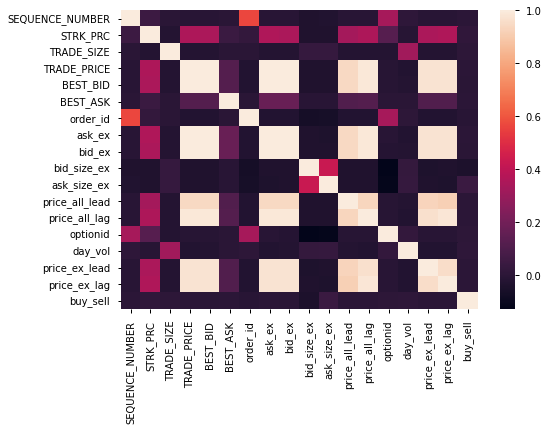

In [17]:
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

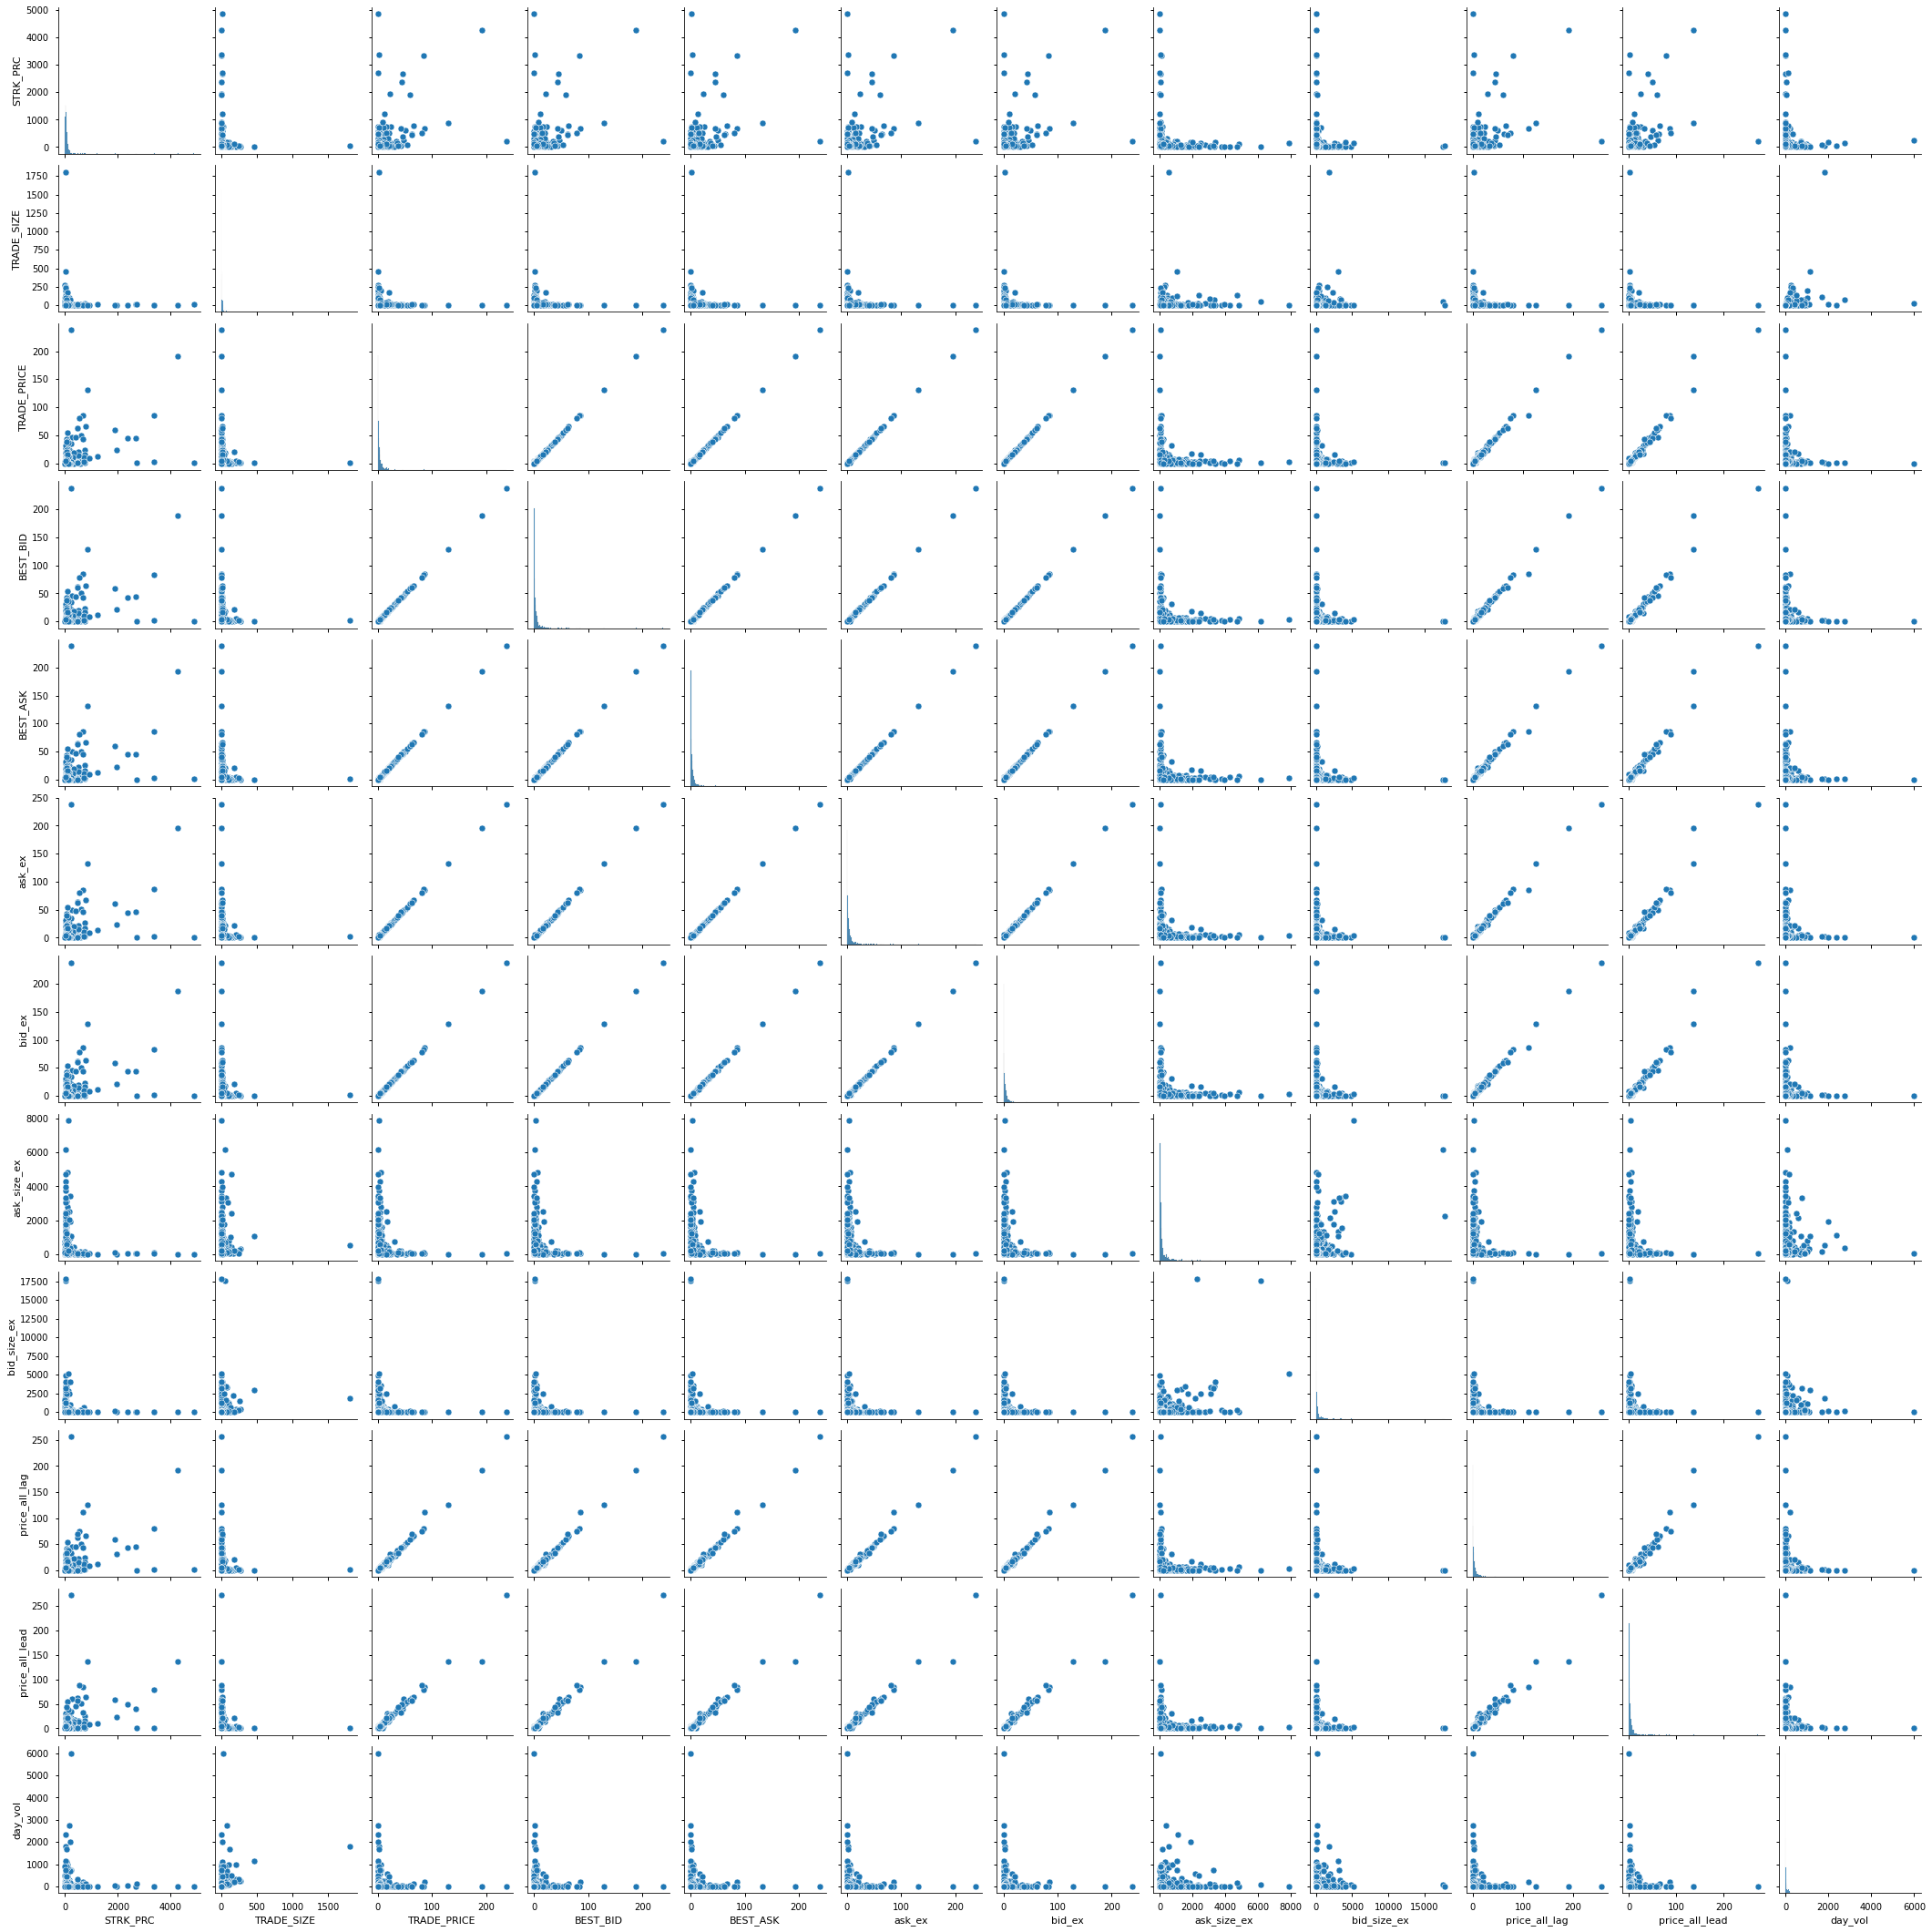

In [18]:
sample = data.sample(n=1000, random_state=seed)
sns.pairplot(sample, vars=["STRK_PRC","TRADE_SIZE", "TRADE_PRICE", "BEST_BID", "BEST_ASK", "ask_ex", "bid_ex", "ask_size_ex", "bid_size_ex", "price_all_lag", "price_all_lead", "day_vol"])

### Correlation with target 🎲

In [137]:
sort_criteria = corr["buy_sell"].abs().sort_values(ascending=False)
corr_target = corr.sort_values("buy_sell", ascending=False)["buy_sell"]
corr_target.loc[sort_criteria.index].to_frame()

,buy_sell
buy_sell,1.000000
ask_size_ex,0.045592
bid_size_ex,-0.042428
STRK_PRC,0.013027
day_vol,0.010908
optionid,0.007770
TRADE_SIZE,0.007162
order_id,-0.005313
price_ex_lead,0.003365
price_all_lead,0.000767


**Observation:**
* Overall correlations are relatively low. Typical for financial data.
* Size related features like `ask_size_ex` or `bid_size_ex` have the highest correlation with the target. Thus, can be promising to be included in the model. Consider when constructing feature sets, that size features are included.
* Features like `optionid`, `order_id`, and `SEQUENCE_NUMBER` are also among the features with the highest correlations. Remove misleading columns.

In [139]:
# remove some columns, which will NOT be used in model
data.drop(columns=["optionid","SEQUENCE_NUMBER", "order_id"], inplace=True)

In [179]:
# just keep ROOT
data.drop(columns="UNDERLYING_SYMBOL", inplace=True)

### Collinearity of features 🎲

In [149]:
# adapted from here: https://www.kaggle.com/code/willkoehrsen/featuretools-for-good

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.975)]

print(to_drop)

['BEST_BID', 'ask_ex', 'bid_ex', 'price_all_lag', 'price_ex_lead', 'price_ex_lag']


In [144]:
# Set the threshold
threshold = 0.975

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr:
    above_threshold_vars[col] = list(corr.index[corr[col] > threshold])

In [148]:
correlating_cols = pd.Series(above_threshold_vars)
correlating_cols

SEQUENCE_NUMBER                                    [SEQUENCE_NUMBER]
STRK_PRC                                                  [STRK_PRC]
TRADE_SIZE                                              [TRADE_SIZE]
TRADE_PRICE        [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_BID           [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
BEST_ASK                                                  [BEST_ASK]
order_id                                                  [order_id]
ask_ex             [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_ex             [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
bid_size_ex                                            [bid_size_ex]
ask_size_ex                                            [ask_size_ex]
price_all_lead                                      [price_all_lead]
price_all_lag      [TRADE_PRICE, BEST_BID, ask_ex, bid_ex, price_...
optionid                                                  [optionid]
day_vol                           

**Observations:**
* Some columns are highly correlated. This is very intuitive.
* It seems problematic to include both `BEST_BID` and `bid_ex`. This is also true for `BEST_ASK` and `ask_ex`. `price_all_lead` and `price_all_lag` seem to be less problematic.
* Define feature sets as such, that the number of highly correlated variables is minimized. But maintain groups so that a comparsion with classical rules is still possible.

## Preparation 🥗

### Visualization helper 🐜

In [ ]:
def kde_target(var_name:str, clip:Optional[List[float]]=None):
  """
  Plot kde plots for buys (+1) and sells (-1) with regard to \
  the feature 'var_name'.

  Args:
      var_name (str): name of the feature
      clip (Optional[List[float]], optional): clipping range. Defaults to None.
  """
  corr_var = data["buy_sell"].corr(data[var_name])

  median_sell = data[data['buy_sell'] == -1][var_name].median()
  median_buy = data[data['buy_sell'] == 1][var_name].median()

  fig, ax = plt.subplots()
  for i in [-1,1]:
    sns.kdeplot(data=data[data["buy_sell"]==i], x=var_name, clip=clip, label=str(i), cumulative=False, common_grid=True)
  ax.title.set_text(f"Distribution of '{var_name}'")
  ax.legend()
  sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
  plt.show()
  print(f"The correlation between {var_name} and the 'buy_sell' is {corr_var: 0.4f}")
  print(f'Median value of sells = {median_sell: 0.4f}') 
  print(f'Median value of buys = {median_buy: 0.4f}')  

In [ ]:
us_rec = web.DataReader("USREC", "fred", data["date"].min(), data["date"].max())


def plot_recessions()->None:
    """
    Add recession indicator to plot and entry to legend.
    """
    l = 0
    month = relativedelta(months=+1)
    for i, (date, val) in enumerate(us_rec["USREC"].items()):
        if val == 1:
            # if boolean = 1 -> print bar until next month
            # _ labels are ignored in legend https://stackoverflow.com/a/44633022/5755604
            plt.axvspan(date, date + month, edgecolor="none", alpha=0.25, label =  "_"*l + "recession")
            l += 1

In [197]:
def plot_time_series(feature: str, aggregation:str="count")->pd.Series:
    """
    Plot feature over time. Aggregate using 'aggregation'.

    Args:
        feature (str): feature to plot.
        aggregation (str, optional): aggregation operation. Defaults to "count".
    
    Returns:
        pd.Series: time series
    """
    time_series = data[[feature]].groupby(data["date"]).agg(aggregation)

    ax = sns.lineplot(data=time_series,x="date", y=feature, label=aggregation)
    ax.yaxis.label.set_text(aggregation)
    ax.title.set_text(f"'{feature}' over time")
    plot_recessions()
    ax.legend()
    plt.show()
    
    return time_series[feature]

### Time features ⏰

In [25]:
# apply positional encoding to dates
data["date_month_sin"] = np.sin(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)
data["date_month_cos"] = np.cos(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)

# time (daily)
seconds_in_day = 24*60*60
seconds = (data["QUOTE_DATETIME"] - data["QUOTE_DATETIME"].dt.normalize()).dt.total_seconds()

data["date_time_sin"] = np.sin(2*  np.pi* seconds / seconds_in_day)
data["date_time_cos"] = np.cos(2 * np.pi* seconds / seconds_in_day)

# year min-max scaled
data["date_year_min"] = (data["QUOTE_DATETIME"].dt.year - 2005) / (2017 - 2005)

# time to maturity
data["ttm"] = (
    data["EXPIRATION"].dt.to_period("M")
    - data["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)

# day, month and year
data["day"] = data["QUOTE_DATETIME"].dt.day
data["month"] = data["QUOTE_DATETIME"].dt.month
data["year"] = data["QUOTE_DATETIME"].dt.year
data["date"] = data["QUOTE_DATETIME"].dt.date

### Binned features 🥫

Bin features similarily to how they are used in the robustness tests.

In [26]:
bins_tradesize = [0, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
data["TRADE_SIZE_binned"] = pd.cut(
    data["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2004, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
data["year_binned"] = pd.cut(data["year"], bins_years, labels=year_labels)

bins_ttm = [-1, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
data["ttm_binned"] = pd.cut(data["ttm"], bins_ttm, labels=ttm_labels)

### Trade features 💴
Construct features that are used in classical rules.

In [27]:
# Degree how much trade size is filled
data["rel_bid_size_ex"] = data["TRADE_SIZE"] / data["bid_size_ex"]
data["rel_ask_size_ex"] = data["TRADE_SIZE"] / data["ask_size_ex"]

# spread in $ between ask and bid
data['spread_ex'] = data['ask_ex'] - data['bid_ex']

# Calculate change similar to tick rule
data["chg_lead_ex"] = data["TRADE_PRICE"] - data["price_ex_lead"]

# Calculate change similar to reverse tick rule
data["chg_lag_ex"] = data["TRADE_PRICE"]- data["price_ex_lag"]

# Midspread
mid = 0.5 * (data["ask_ex"] + data["bid_ex"])

# Absolute distance from mid
data["abs_mid_ex"] = data["TRADE_PRICE"] - mid
data["mid_ex"] = mid

### Underlying features 🫀

In [ ]:
data["symbol_is_index"] = data['UNDERLYING_SYMBOL'].str.startswith("^")

# special code from 5th character in symbol
data["special_code"] = data['UNDERLYING_SYMBOL'].str[4]

# Security type similar to Grauer et. al p. 35
data['security_type'] = np.where(data["symbol_is_index"],"index option", np.where(data["special_code"].notnull(),"other", "stock option"))
data['security_type'] = data['security_type'].astype("category")

### Categorical features 🎰

In [ ]:
# binarize

# select categorical e. g., option type and strings e. g., ticker
cat_columns = data.select_dtypes(include=["category", "object"]).columns.tolist()
print(cat_columns)

cat_columns_bin = ["bin_" + x for x in cat_columns]

# binarize categorical similar to Borisov et al.
data[cat_columns_bin] = data[cat_columns].apply(lambda x: pd.factorize(x)[0])

## General overview 🌄

### Trades over time ⌚

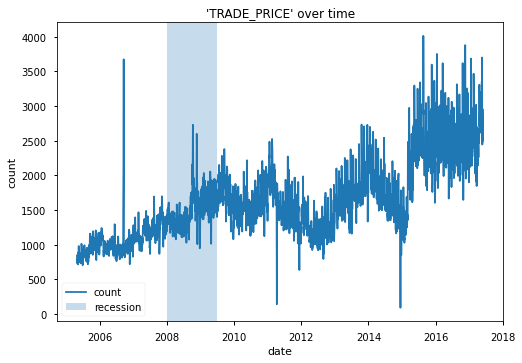

In [192]:
trades_per_day = plot_time_series("TRADE_PRICE", "count")

In [194]:
trades_per_day.nlargest(N)

date
2015-08-21    4013
2016-11-18    3880
2016-01-15    3753
2017-05-19    3701
2017-01-20    3686
2006-09-19    3675
2016-10-21    3620
2016-03-18    3619
2015-11-20    3599
2017-02-17    3467
Name: TRADE_PRICE, dtype: int64

In [195]:
trades_per_day.nsmallest(N)

date
2014-12-15     93
2011-04-11    144
2011-12-12    637
2005-06-30    706
2005-05-11    718
2005-08-25    719
2006-11-24    721
2005-08-26    726
2005-05-06    729
2005-06-10    733
Name: TRADE_PRICE, dtype: int64

**Observation:**
* Number of trades increases over time.
* There is no obvious explanation why the number of trades spikes at certain days.

### Trade size over time ⌚

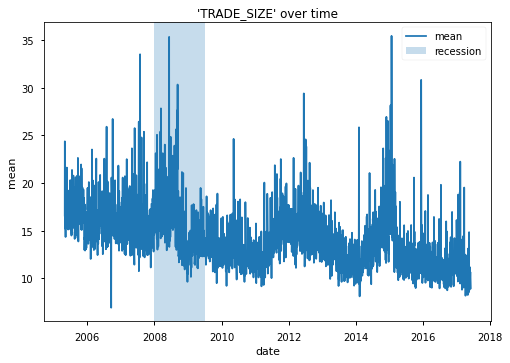

In [199]:
sizes_per_day = plot_time_series("TRADE_SIZE", "mean")

In [36]:
data[data["TRADE_SIZE"].max()==data["TRADE_SIZE"]]

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,TRADE_SIZE_binned,year_binned,ttm_binned,rel_bid_size_ex,rel_ask_size_ex,spread_ex,chg_lead_ex,chg_lag_ex,abs_mid_ex,mid_ex
39949553,SVU,2015-12-11 15:22:27,51029631,SVU,2016-01-15,5.0,C,48332,1.7,1.55,...,>11,2015,ttm <= 1 month,85.241623,177.040298,0.2,NaN,-1.52,0.05,1.65


**Observation:**
* There is a slow downward trend in `TRADE_SIZE`.
* Controversely, the average number of trades per day increases over time.
* Market share of ISE has decrease over time, as reported in https://www.sifma.org/wp-content/uploads/2022/03/SIFMA-Insights-Market-Structure-Compendium-March-2022.pdf. 

### Buy Sell 👛

In [37]:
ratio_buy_sell = data["buy_sell"].value_counts() / data["buy_sell"].count()
ratio_buy_sell

-1    0.52569
 1    0.47431
Name: buy_sell, dtype: float64

**Observation:**
* Ratios similar to the one reported in Grauer et. al. Yet not identical as calculation is done on a sample.
* As both classes have a $\approx~0.5$ probability, I would not rebalance. Rebalancing through sampling etc. itself has a bias.
* Ratios seem to be stable over time (see below). Thus, distribution is similar for training, validation, and test set.

#### By option type

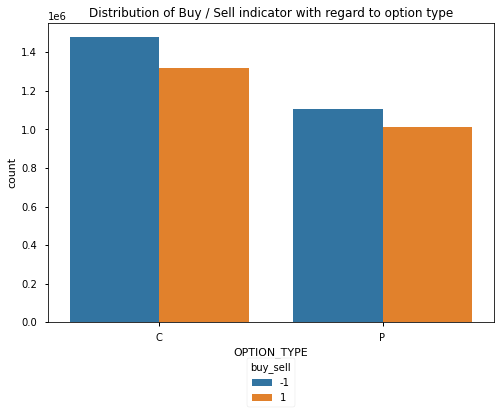

In [38]:
ax = sns.countplot(data=data,x="OPTION_TYPE", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to option type")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))

#### By year

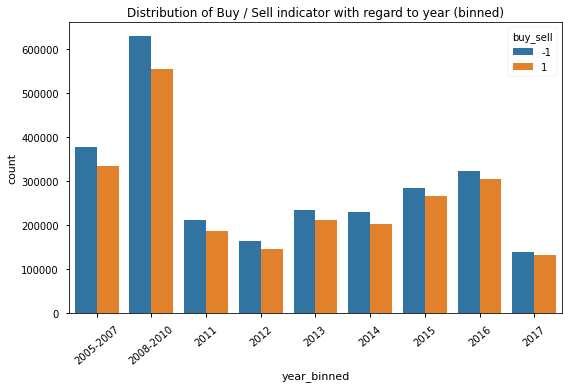

In [39]:
ax = sns.countplot(data=data,x="year_binned", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to year (binned)")
# sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
plt.tight_layout()
plt.show()

#### By time time to maturity

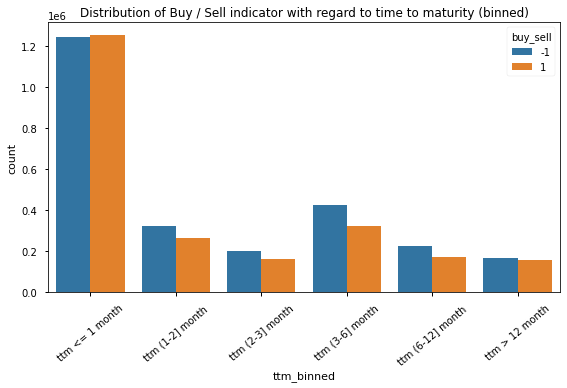

In [40]:
ax = sns.countplot(data=data,x="ttm_binned", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to time to maturity (binned)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
plt.tight_layout()
plt.show()

#### Over time

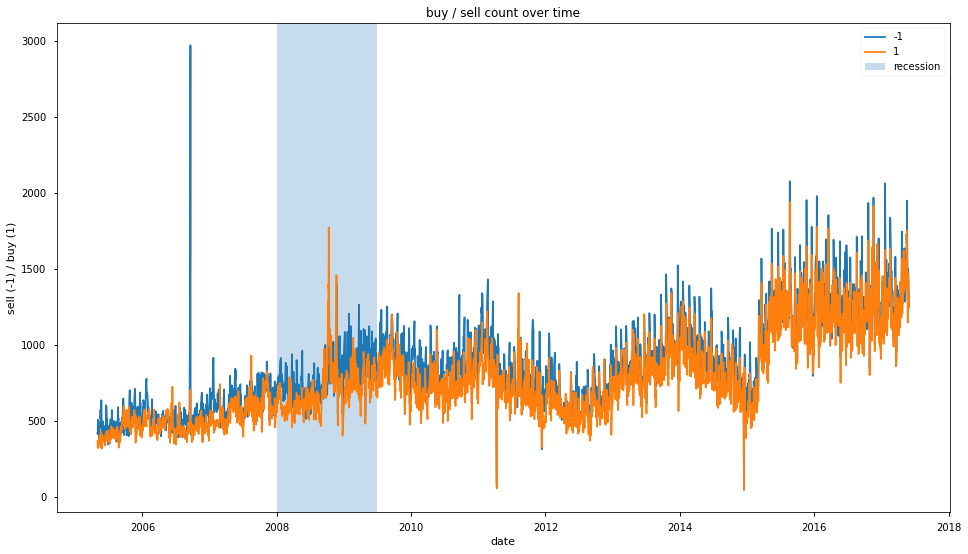

In [42]:
trades_over_time = data.groupby(data['date'])["buy_sell"].value_counts().unstack(fill_value=0)
ax = trades_over_time.plot(kind="line", figsize=ratio, title="buy / sell count over time", xlabel="date", ylabel="sell (-1) / buy (1)")
plot_recessions()
ax.legend()
plt.show()

### $n$ most frequent symbols, indices, and special codes 🔢

In [52]:
alphanumeric_symbols = data[~data['UNDERLYING_SYMBOL'].str.isalpha()]
alphanumeric_symbols.drop_duplicates(inplace=True)
print(alphanumeric_symbols.values)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


[['^RUT' Timestamp('2007-01-09 11:21:24') 23022888 ... 0.5
  0.04999995231628418 3.950000047683716]
 ['^RUT' Timestamp('2011-08-10 16:11:13') 387476785 ... nan
  0.0500030517578125 97.0999984741211]
 ['^RUT' Timestamp('2008-11-20 10:26:49') 43065153 ... 19.0
  0.5500030517578125 113.44999694824219]
 ...
 ['BF.B' Timestamp('2015-04-13 09:53:26') 563025100 ...
  -0.6499999761581421 -0.025000005960464478 0.17500001192092896]
 ['^NDX' Timestamp('2010-08-25 11:02:52') 67891827 ... 3.4000244140625
  3.6500244140625 1068.75]
 ['^NDX' Timestamp('2015-07-15 09:58:52') 82428263 ...
  -0.26000022888183594 0.1099996566772461 12.100000381469727]]


In [53]:
overlong_symbols = data[data['UNDERLYING_SYMBOL'].str.len()>=5]
overlong_symbols.drop_duplicates(inplace=True)
print(overlong_symbols.values)

[['GOOGL' Timestamp('2014-11-19 12:30:52') 2701280801 ... nan
  0.014999985694885254 1.0750000476837158]
 ['DYNIQ' Timestamp('2008-08-26 09:30:18') 287302 ... 0.01000000536441803
  0.015000000596046448 0.07500000298023224]
 ['GULTU' Timestamp('2011-03-16 14:05:24') 186077629 ...
  -0.8500000238418579 -0.034999966621398926 1.3949999809265137]
 ...
 ['SMHYL' Timestamp('2010-06-16 09:40:15') 17770071 ...
  -0.009999990463256836 0.019999980926513672 2.8299999237060547]
 ['GULTU' Timestamp('2011-06-06 14:54:38') 72795419 ...
  0.6500000357627869 -0.004999876022338867 1.4649999141693115]
 ['DYNIQ' Timestamp('2008-02-05 10:06:53') 18166341 ...
  -0.09999996423721313 -0.050000011920928955 0.6000000238418579]]


,Symbol,Count
0,SPY,113324
1,AAPL,59121
2,IWM,53685
3,GLD,42116
4,^NDX,39492
5,GOOG,38873
6,AMZN,37159
7,DIA,36516
8,TLT,32319
9,PCLN,31622


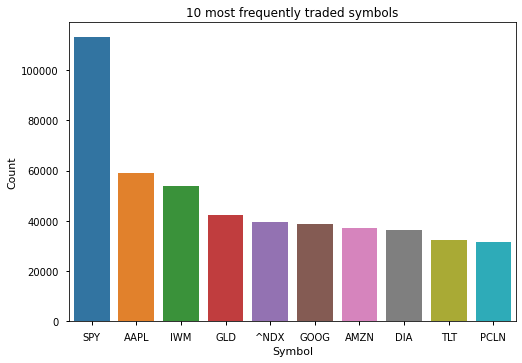

In [54]:
most_frequent_symbols = data["UNDERLYING_SYMBOL"].value_counts().head(N).reset_index(name="Count")
most_frequent_symbols.rename(columns={'index':'Symbol'}, inplace=True)

ax = sns.barplot(data=most_frequent_symbols, x="Symbol", y="Count")
ax.title.set_text(f"{N} most frequently traded symbols")
most_frequent_symbols

In [55]:
list_freq_symbols = most_frequent_symbols.Symbol.tolist()

In [56]:
frequent_symbols_over_time = data[data["UNDERLYING_SYMBOL"].isin(list_freq_symbols)]

In [57]:
frequent_symbols_trades_per_day = frequent_symbols_over_time.groupby([frequent_symbols_over_time.QUOTE_DATETIME.dt.to_period('m'), "UNDERLYING_SYMBOL"])["TRADE_SIZE"].count().reset_index().rename(columns={"TRADE_SIZE": "count", "QUOTE_DATETIME": "date", "UNDERLYING_SYMBOL": "Symbol"})


In [58]:
frequent_symbols_trades_per_day.head()

,date,Symbol,count
0,2005-05,AAPL,109
1,2005-05,AMZN,47
2,2005-05,GOOG,174
3,2005-05,IWM,153
4,2005-05,PCLN,26


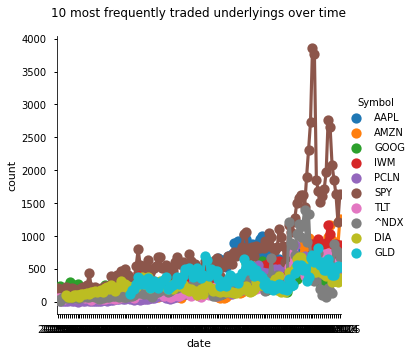

In [59]:
plot = sns.catplot(data=frequent_symbols_trades_per_day, x="date", y="count", hue='Symbol', kind="point")
plot.figure.subplots_adjust(top=0.9)
plot.figure.suptitle(f"{N} most frequently traded underlyings over time");

In [60]:
frequent_symbols_over_time

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,TRADE_SIZE_binned,year_binned,ttm_binned,rel_bid_size_ex,rel_ask_size_ex,spread_ex,chg_lead_ex,chg_lag_ex,abs_mid_ex,mid_ex
33645515,AAPL,2014-09-17 13:24:38,1624573500,AAPL,2015-01-17,128.570007,C,5,0.360000,0.340000,...,"(3,5]",2014,ttm (3-6] month,0.113636,1.000000,0.030000,-0.010000,0.010000,0.015000,0.345000
5285911,AMZN,2007-06-04 15:19:47,38300704,ZQN,2007-07-21,80.000000,P,10,10.300000,10.100000,...,"(5,11]",2005-2007,ttm <= 1 month,0.068966,0.009804,0.299999,1.000000,-1.200000,0.050000,10.250000
18345553,DIA,2010-11-09 15:56:19,104869698,DIA,2010-12-31,113.000000,C,1,2.650000,2.610000,...,"(0,1]",2008-2010,ttm <= 1 month,0.024390,0.012048,0.040000,0.470000,-0.350000,0.020000,2.630000
37830620,DIA,2015-08-10 10:27:28,10602712,DIA,2015-11-20,174.000000,P,12,5.040000,4.950000,...,>11,2015,ttm (2-3] month,0.016925,0.024845,0.150000,-0.550000,0.390000,0.015000,5.025000
25346446,TLT,2012-10-16 15:53:43,42017150,TLT,2013-03-16,128.000000,P,2,9.840000,9.800000,...,"(1,3]",2012,ttm (3-6] month,1.000000,0.005650,0.099999,0.670000,0.530000,-0.010000,9.850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4137102,GOOG,2007-01-10 09:39:15,3139815,GOO,2007-01-20,600.000000,P,1,115.800003,115.300003,...,"(0,1]",2005-2007,ttm <= 1 month,0.090909,0.100000,0.500000,20.100006,3.400002,0.250000,115.550003
15111546,GOOG,2010-01-13 12:22:12,35369415,OUP,2011-01-22,550.000000,C,1,86.099998,86.099998,...,"(0,1]",2008-2010,ttm (6-12] month,0.023256,0.032258,1.300003,-3.800003,-12.900002,-0.650002,86.750000
17469205,^NDX,2010-08-25 11:02:52,67891827,NDX,2010-09-18,700.000000,C,20,1072.400024,1065.199951,...,>11,2008-2010,ttm <= 1 month,0.181818,0.800000,7.300049,-94.099976,3.400024,3.650024,1068.750000
35551114,SPY,2015-03-23 12:15:51,29177977,SPY,2015-06-30,85.000000,P,100,0.010000,0.000000,...,>11,2015,ttm (2-3] month,inf,0.460829,0.020000,NaN,-0.060000,0.000000,0.010000


,Symbol,Count
0,^NDX,39492
1,^RUT,22218
2,^MNX,2049
3,^MSH,568
4,^RUI,517
5,^CDD,502
6,^EUU,405
7,^YUK,353
8,^EUI,219
9,^GBP,168


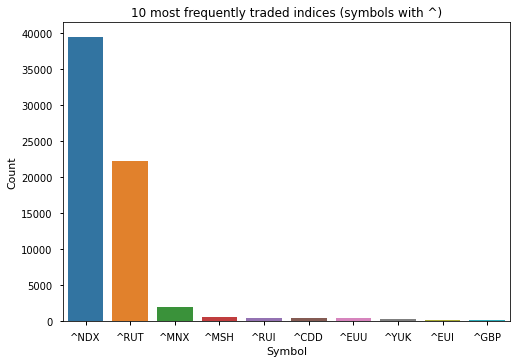

In [62]:
most_frequent_indices = data[data["symbol_is_index"]]["UNDERLYING_SYMBOL"].value_counts().head(N).reset_index(name="Count")
most_frequent_indices.rename(columns={'index':'Symbol'}, inplace=True)

ax = sns.barplot(data=most_frequent_indices, x="Symbol", y="Count")
ax.title.set_text(f"{N} most frequently traded indices (symbols with ^)")
most_frequent_indices

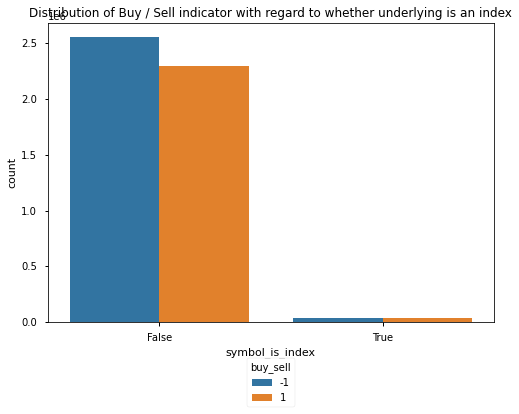

In [63]:
ax = sns.countplot(data=data,x="symbol_is_index", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to whether underlying is an index")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))

In [64]:
ratios_is_index = data.groupby(['symbol_is_index', "buy_sell"])['buy_sell'].count() / data.groupby(["symbol_is_index"])["buy_sell"].count()
ratios_is_index

symbol_is_index  buy_sell
False            -1          0.526288
                  1          0.473712
True             -1          0.482614
                  1          0.517386
Name: buy_sell, dtype: float64

**Observation:**
- Feature can be important, as it's much more likely for trade to be sell, rather than buy, if and only if the underlying is no index option.
- Difference isn't too pronounced and could be due to sampling effects.

In [65]:
# 5th character in symbol
data["special_code"] = data['UNDERLYING_SYMBOL'].str[4]

In [66]:
data["special_code"].value_counts(dropna=False)

NaN    4845957
Q        29294
L        17587
A         9569
B         6740
Y         6096
U         2207
F         1688
K          876
D          175
E          134
R           12
.           10
P           10
S            9
X            4
N            3
V            3
O            1
Name: special_code, dtype: int64

**Observation:**
* `L`: Misc. (compare Google Shares)
* `B`: Class "B"
* `A`: Class "A"
* `K`: "Non-voting"
* `X`: "Mutual funds"
* `Y`: "ADRs"

Grauer et al. also include ETFs in `others`. Not sure how they are identified.

In [67]:
# Security type similar to Grauer et. al p. 35
data['security_type'] = np.where(data["symbol_is_index"],"index option", np.where(data["special_code"].notnull(),"other", "stock option"))
data['security_type'] = data['security_type'].astype("category")

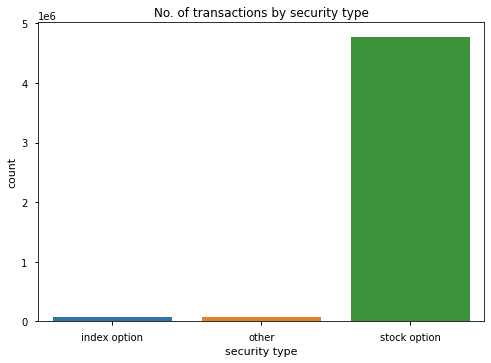

In [68]:
ax = sns.countplot(data=data,x="security_type")
ax.title.set_text("No. of transactions by security type")
ax.xaxis.label.set_text("security type")

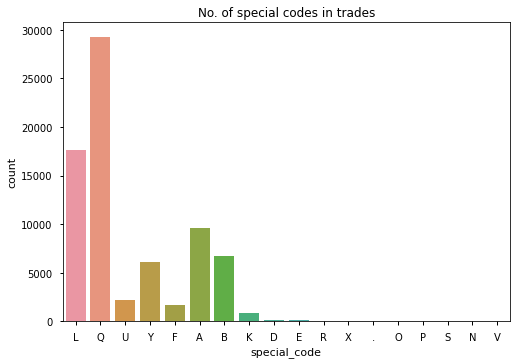

In [69]:
ax = sns.countplot(data=data, x = "special_code")
ax.title.set_text("No. of special codes in trades")

# Time to Maturity ⌚

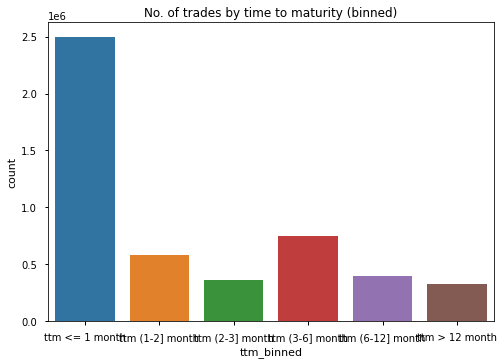

In [114]:
ax = sns.countplot(data=data, x = "ttm_binned")
ax.title.set_text("No. of trades by time to maturity (binned)")

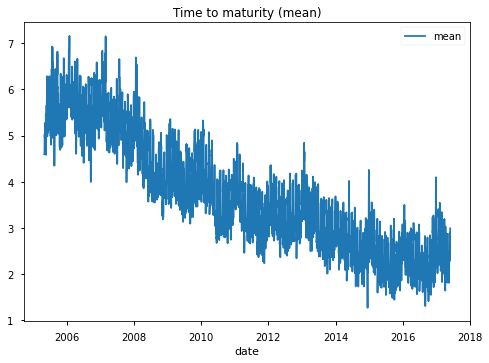

In [115]:
mean_time_2_maturity = data["ttm"].groupby(data['date']).agg(['mean'])
ax = sns.lineplot(mean_time_2_maturity)
ax.title.set_text("Time to maturity (mean)")

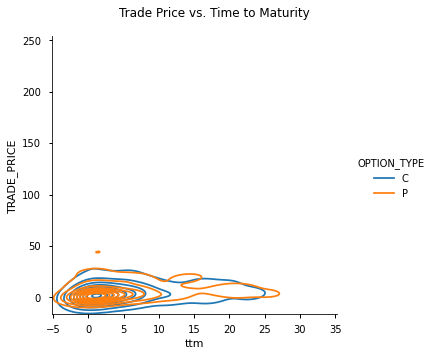

In [116]:
sample = data.sample(n=1000, random_state=seed)

plot = sns.displot(data = sample, 
                x = "ttm", 
                y = "TRADE_PRICE", kind="kde", hue="OPTION_TYPE")
plot.figure.subplots_adjust(top=0.9)
plot.figure.suptitle("Trade Price vs. Time to Maturity");

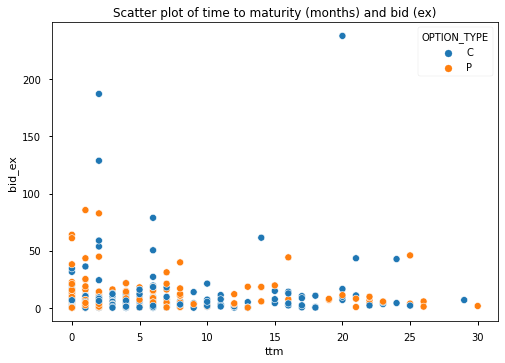

In [117]:
ax = sns.scatterplot(data = sample, 
                x = "ttm", 
                y = "bid_ex",
                hue= "OPTION_TYPE")
ax.title.set_text("Scatter plot of time to maturity (months) and bid (ex)")

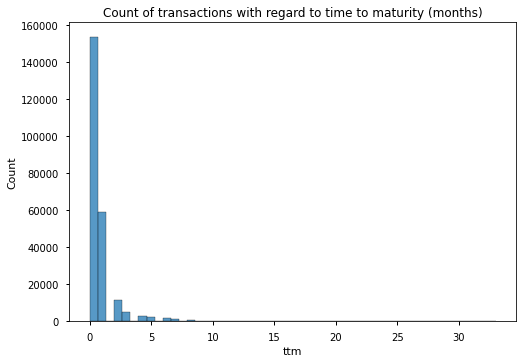

In [118]:
ax = sns.histplot(data = data[data["bid_ex"]==0.0], 
                  x = "ttm", bins=50)
ax.title.set_text("Count of transactions with regard to time to maturity (months)")

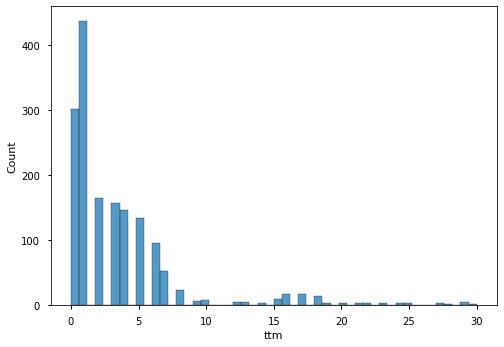

In [119]:
# TODO: ask of zero plausible?
sns.histplot(data = data[data["ask_ex"]==0.0], 
                x = "ttm", bins=50)

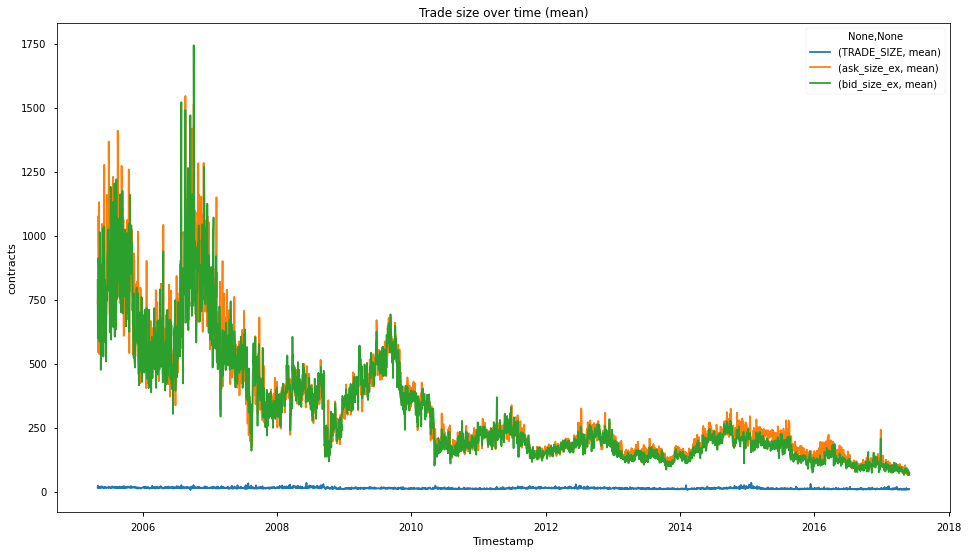

In [120]:
trades_over_time = data[["TRADE_SIZE", "ask_size_ex", "bid_size_ex"]].groupby(data['date']).agg(['mean'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade size over time (mean)", xlabel="Timestamp", ylabel="contracts")

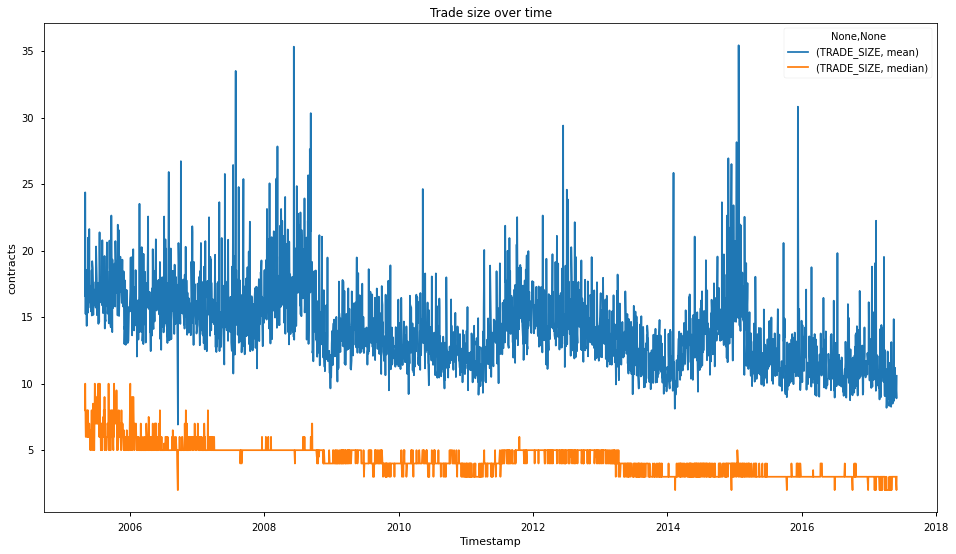

In [121]:
trades_over_time = data[["TRADE_SIZE"]].groupby(data['date']).agg(['mean','median'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade size over time", xlabel="Timestamp", ylabel="contracts")

###  bid ex 

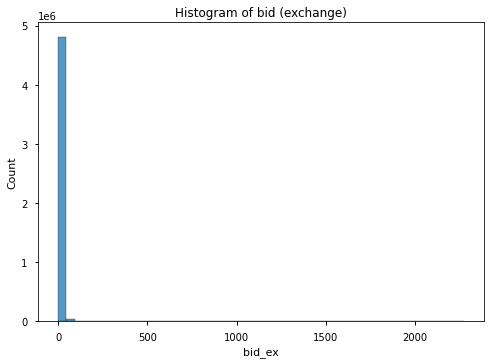

In [ ]:
ax = sns.histplot(data, x="bid_ex", bins=50)
ax.title.set_text("Histogram of bid (exchange)")

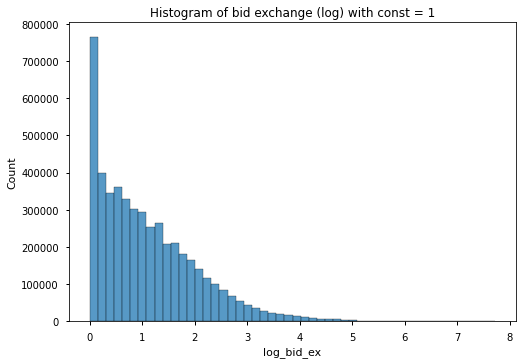

In [ ]:
const = 1
data['log_bid_ex'] = np.log(data["bid_ex"]+const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)
ax.title.set_text(f"Histogram of bid exchange (log) with const = {const}")

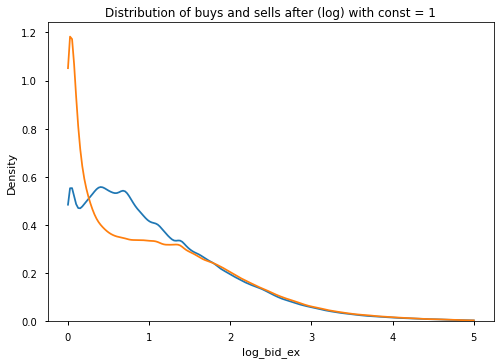

In [ ]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="log_bid_ex", clip=[0, 5], label=str(i), cumulative=False)
ax.title.set_text(f"Distribution of buys and sells after (log) with const = {const}")

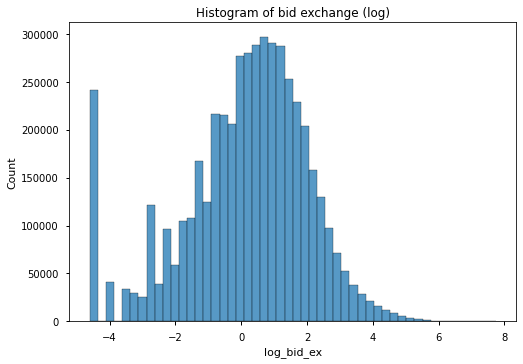

In [ ]:
const = 1e-2
data['log_bid_ex'] = np.log(data["bid_ex"]+const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)
ax.title.set_text("Histogram of bid exchange (log)")

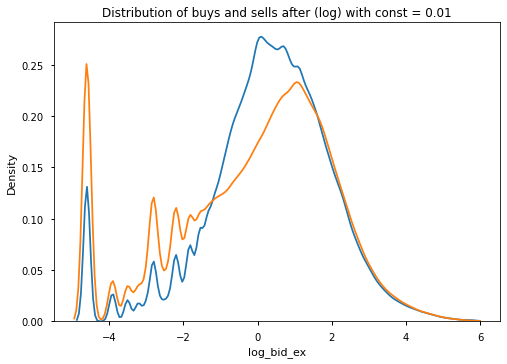

In [ ]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="log_bid_ex", clip=[-5, 6], label=str(i), cumulative=False)

ax.title.set_text(f"Distribution of buys and sells after (log) with const = {const}")

**Observation:**
- One can choose different constants, but small constants, e. g., `const=1e-2` gives fuzzy results. Better choose larger constant like `const=1`.

## Quote rule ✔️

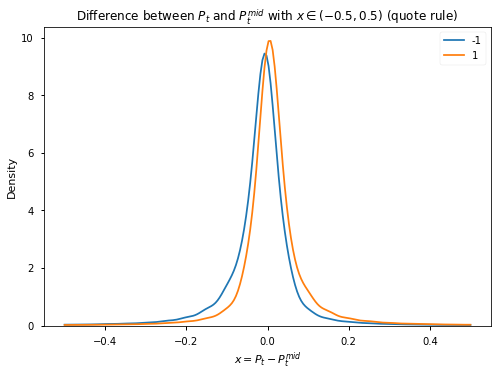

In [46]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="abs_mid_ex",clip=[-0.5, 0.5], label=str(i), cumulative=False)

ax.title.set_text("Difference between $P_{t}$ and $P_{t}^{mid}$ with $x \in(-0.5, 0.5)$ (quote rule)")
ax.xaxis.label.set_text("$x = P_{t} - P_{t}^{mid}$")
ax.legend()
#sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

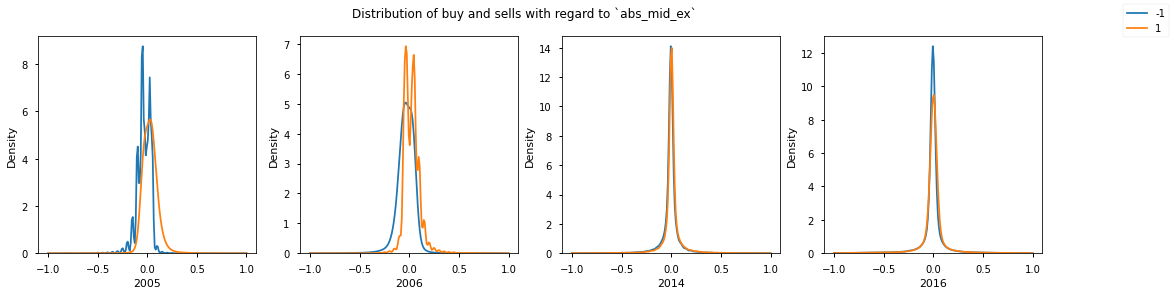

In [47]:
years = [2005, 2006, 2014, 2016]
f, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 4))

f.suptitle("Distribution of buy and sells with regard to `abs_mid_ex`")

for y, year in enumerate(years):
  for i in [-1,1]:
    sns.kdeplot(data=data[(data["buy_sell"]==i) & (data["year"] == year)], x="abs_mid_ex", clip=[-1, 1], label="_" * y + str(i), cumulative=False, common_grid=True, ax=ax[y])
    ax[y].xaxis.label.set_text(str(year))

f.legend()

**Observations:**
- `TODO:` Analyze effects that lead to a fuzzy distribution at the beginning of the sample, but largely overlapping distributions at the end.

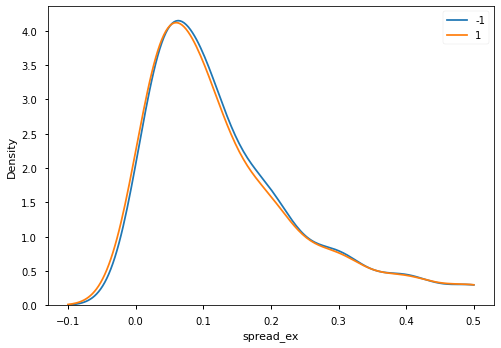

In [48]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="spread_ex",clip=[-0.1, 0.5], label=str(i), cumulative=False)

# ax.title.set_text("Difference between $P_{t}$ and $P_{t}^{mid}$ with $x \in(-0.5, 0.5)$ (quote rule)")
# ax.xaxis.label.set_text("$x = P_{t} - P_{t}^{mid}$")
ax.legend()
plt.show()

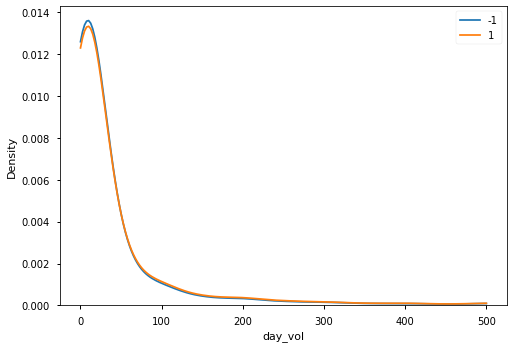

In [49]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="day_vol", clip=[0, 500], label=str(i), cumulative=False)
# clip=[-0.5, 0.5]
# ax.title.set_text("Difference between $P_{t}$ and $P_{t}^{mid}$ with $x \in(-0.5, 0.5)$ (quote rule)")
# ax.xaxis.label.set_text("$x = P_{t} - P_{t}^{mid}$")
ax.legend()
#sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

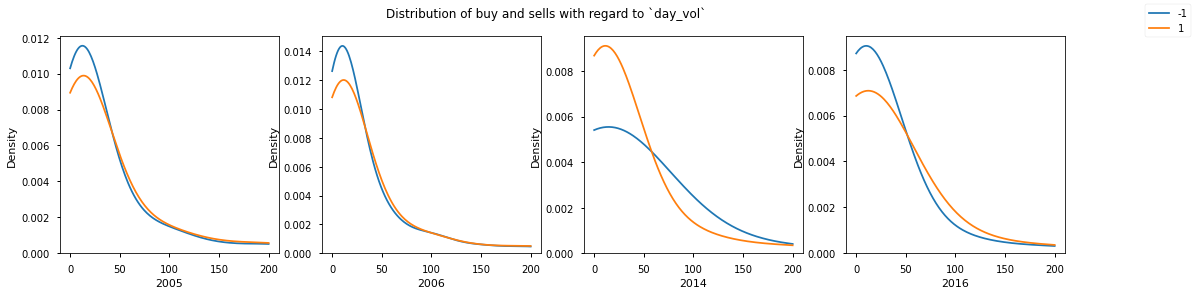

In [50]:
years = [2005, 2006, 2014, 2016]
f, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 4))

f.suptitle("Distribution of buy and sells with regard to `day_vol`")

for y, year in enumerate(years):
  for i in [-1,1]:
    sns.kdeplot(data=data[(data["buy_sell"]==i) & (data["year"] == year)], x="day_vol", clip=[0, 200], label="_" * y + str(i), cumulative=False, common_grid=True, ax=ax[y])
    ax[y].xaxis.label.set_text(str(year))

f.legend()

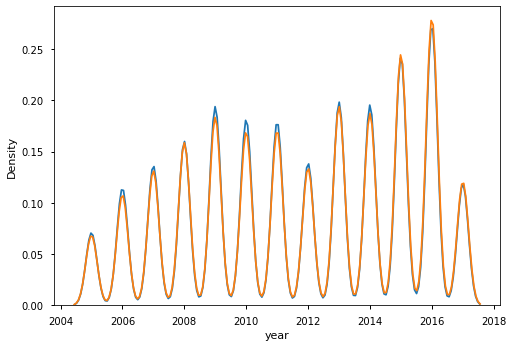

In [51]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="year", label=str(i), cumulative=False)

## Tick test ❌

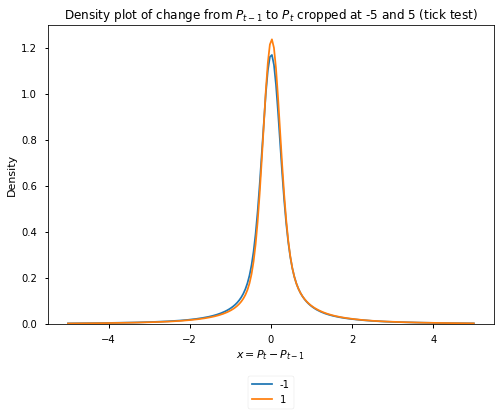

In [43]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="chg_lead_ex", clip=[-5, 5], label=str(i), cumulative=False, common_grid=True)

ax.title.set_text("Density plot of change from $P_{t-1}$ to $P_{t}$ cropped at -5 and 5 (tick test)")
ax.xaxis.label.set_text("$x = P_{t} - P_{t-1}$")
ax.legend()
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

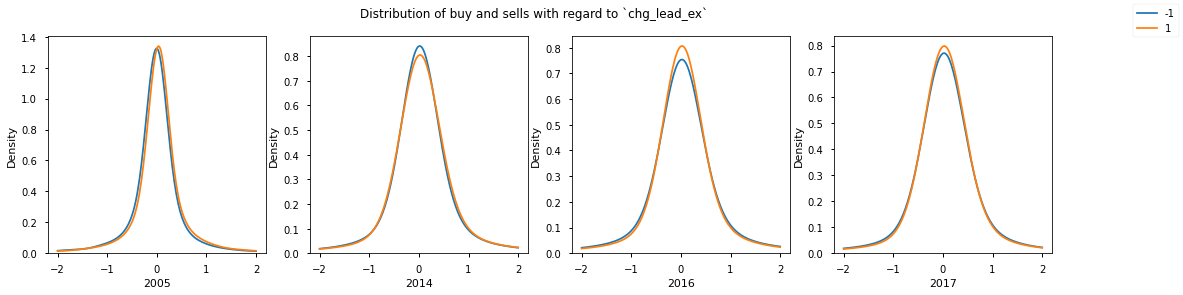

In [44]:

years = [2005, 2014, 2016, 2017]
f, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 4))

f.suptitle("Distribution of buy and sells with regard to `chg_lead_ex`")

for y, year in enumerate(years):
  for i in [-1,1]:
    sns.kdeplot(data=data[(data["buy_sell"]==i) & (data["year"] == year)], x="chg_lead_ex", clip=[-2, 2], label="_" * y + str(i), cumulative=False, common_grid=True, ax=ax[y])
    ax[y].xaxis.label.set_text(str(year))

f.legend()

## Reverse tick test ❌

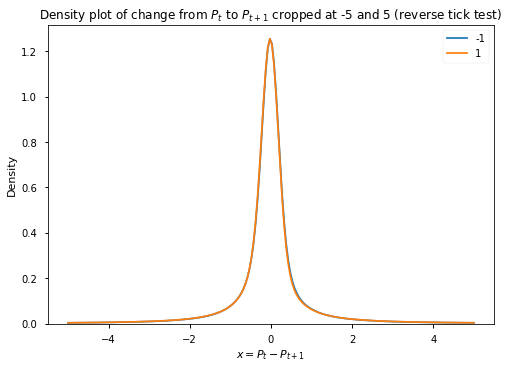

In [45]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="chg_lag_ex", clip=[-5, 5], label=str(i), cumulative=False, common_grid=True)

ax.title.set_text("Density plot of change from $P_{t}$ to $P_{t+1}$ cropped at -5 and 5 (reverse tick test)")
ax.xaxis.label.set_text("$x = P_{t} - P_{t+1}$")
ax.legend()
#sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

## Strike Price 💷

## Trade Prices and Sizes 🤝

### Trade price

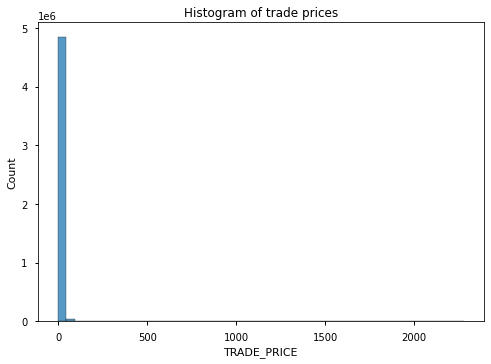

In [70]:
ax = sns.histplot(data, x="TRADE_PRICE", bins=50)
ax.title.set_text("Histogram of trade prices")

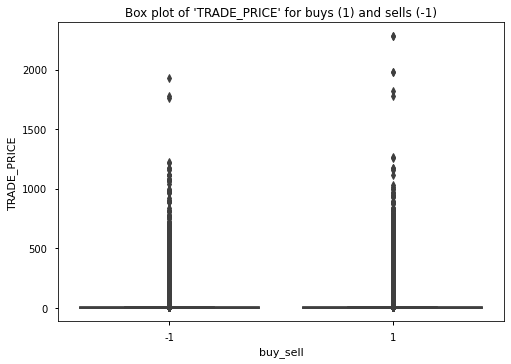

In [71]:
ax = sns.boxplot(data = data, x="buy_sell", y = "TRADE_PRICE")
ax.title.set_text("Box plot of 'TRADE_PRICE' for buys (1) and sells (-1)")

**Observations:**
* Very few very large trade prices, many very small trade prices.
* Scaling can problematic, if outliers affect scaling much. Try $\log(\cdot)$ transform. Could improve results.
* Trade price is hardly informative, as distribution is very similar.

In [73]:
const = 1e-2
data['log_trade_price'] = np.log(data["TRADE_PRICE"] + const)
#data['log_trade_price'].replace([np.inf, -np.inf], np.nan, inplace=True)

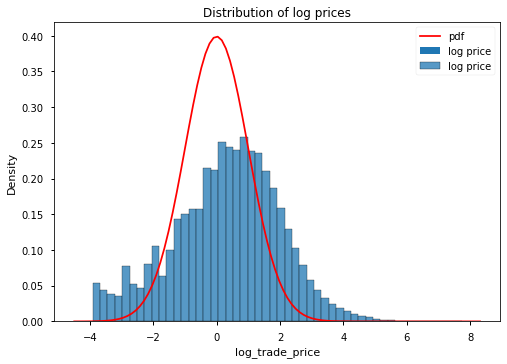

In [74]:
fig, ax = plt.subplots()

sns.histplot(data, x="log_trade_price", bins=50, stat='density', label="log price")

# extract the limits for the x-axis and fit normal distributon
x0, x1 = ax.get_xlim()  
x_pdf = np.linspace(x0, x1, 100)
y_pdf = stats.norm.pdf(x_pdf)

pdf = pd.DataFrame({'x':x_pdf,'y':y_pdf})
sns.lineplot(data = pdf,x='x', y='y',label="pdf", color="r")


ax.title.set_text("Distribution of log prices")                                                   
ax.legend()

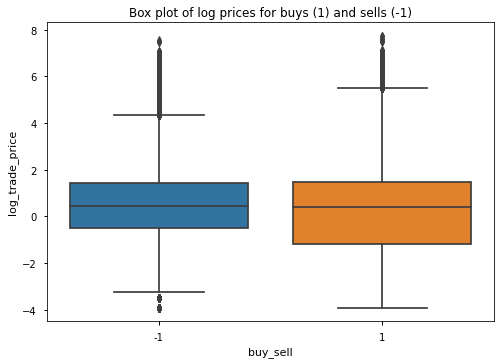

In [75]:
ax = sns.boxplot(data=data, x="buy_sell", y="log_trade_price")
ax.title.set_text("Box plot of log prices for buys (1) and sells (-1)")

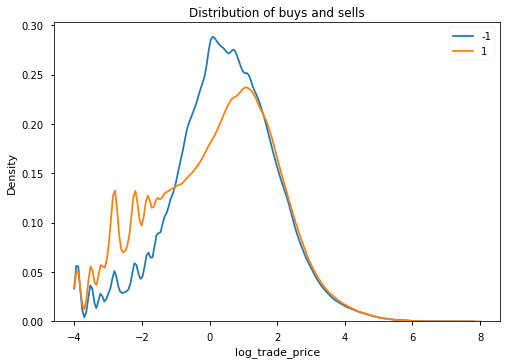

In [76]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="log_trade_price", clip=[-4,8], label=str(i), cumulative=False)

ax.title.set_text("Distribution of buys and sells")
ax.legend()
plt.show()

In [77]:
data.nlargest(N, "TRADE_PRICE", keep='first').T

,33680345,33680332,32486891,32486793,39437552,38759890,38399924,38354215,38922953,14962176
UNDERLYING_SYMBOL,^NDX,^NDX,^NDX,^NDX,^NDX,^NDX,^NDX,^NDX,^NDX,^NDX
QUOTE_DATETIME,2014-09-19 12:21:28,2014-09-19 12:21:14,2014-06-06 10:14:12,2014-06-06 10:12:54,2015-11-11 16:02:27,2015-10-05 09:56:59,2015-09-10 15:40:46,2015-09-08 14:30:03,2015-10-14 09:37:19,2009-12-30 12:13:35
SEQUENCE_NUMBER,2364398603,2361135401,980830903,952279501,31188174,17612557,202073421,135284711,541355374,39872640
ROOT,NDX,NDX,NDX,NDX,NDX,NDX,NDX,NDX,NDX,NDK
EXPIRATION,2014-12-20 00:00:00,2014-12-20 00:00:00,2014-09-20 00:00:00,2014-09-20 00:00:00,2015-11-13 00:00:00,2016-12-16 00:00:00,2016-01-15 00:00:00,2015-12-19 00:00:00,2017-06-16 00:00:00,2010-09-18 00:00:00
STRK_PRC,1800.0,1800.0,1800.0,1800.0,2700.0,6100.0,2500.0,2500.0,6100.0,600.0
OPTION_TYPE,C,C,C,C,C,P,C,C,P,C
TRADE_SIZE,3,1,3,3,1,1,1,1,3,4000
TRADE_PRICE,2281.97998,2281.48999,1975.849976,1975.699951,1932.869995,1816.579956,1776.219971,1775.48999,1761.780029,1266.430054
BEST_BID,2278.100098,2278.100098,1973.5,1973.5,1925.5,1808.0,1766.400024,1773.199951,1756.099976,1264.300049


In [78]:
data.nsmallest(N, "TRADE_PRICE", keep='first').T

,48104749,19780542,10715752,11185445,27164978,38450533,11568455,15659156,42921907,46721572
UNDERLYING_SYMBOL,XME,SLV,VLO,BKC,TBT,T,INTC,FAZ,XME,SPY
QUOTE_DATETIME,2017-04-04 11:04:45,2011-03-03 11:44:50,2009-01-02 12:09:42,2009-02-13 15:27:11,2013-04-17 11:08:08,2015-09-15 10:36:28,2009-03-19 15:34:08,2010-03-09 09:36:38,2016-06-06 12:30:06,2017-01-13 13:24:43
SEQUENCE_NUMBER,35527956,89224478,35098957,15428077,50718351,1153824948,18083073,3696840,153844348,89415734
ROOT,XME,SLV,VLO,BKC,TBT,T,NQ,FAY,XME,SPY
EXPIRATION,2017-04-21 00:00:00,2011-03-19 00:00:00,2009-01-17 00:00:00,2009-02-21 00:00:00,2013-04-20 00:00:00,2015-09-18 00:00:00,2009-03-21 00:00:00,2010-03-20 00:00:00,2016-06-17 00:00:00,2017-01-18 00:00:00
STRK_PRC,35.0,25.0,45.0,15.0,64.0,34.0,17.0,35.0,30.0,238.5
OPTION_TYPE,C,P,C,P,C,C,C,C,C,C
TRADE_SIZE,2,41,2,10,1,10,1,4,1,30
TRADE_PRICE,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
BEST_BID,0.0,0.01,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


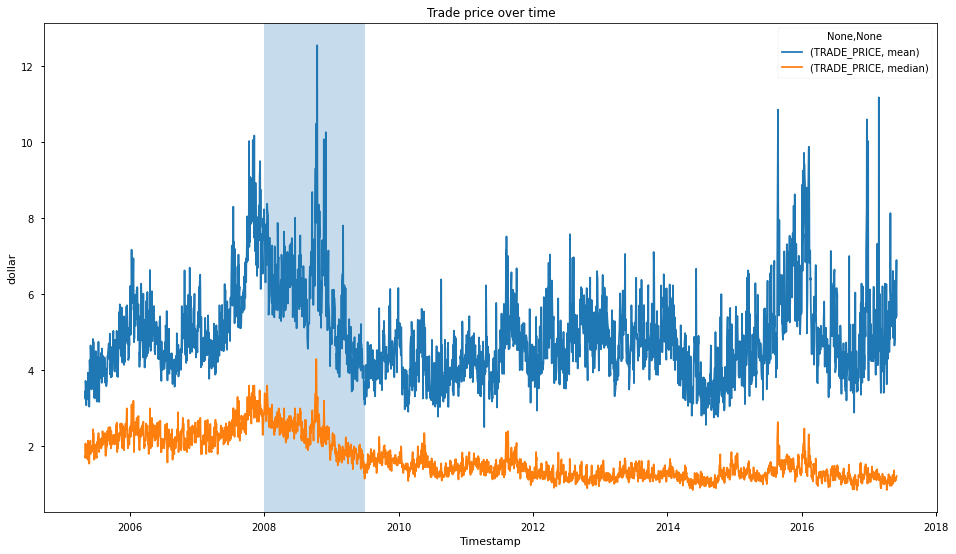

In [79]:
trades_over_time = data[["TRADE_PRICE"]].groupby(data['date']).agg(['mean','median'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade price over time", xlabel="Timestamp", ylabel="dollar")

plot_recessions()
plt.show()

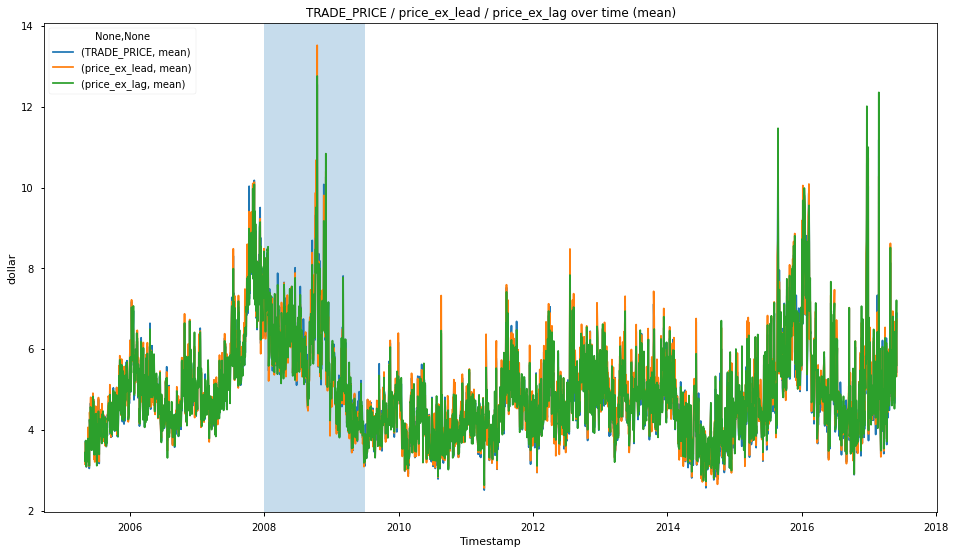

In [80]:
lead_lag_trade_price = data[["TRADE_PRICE", "price_ex_lead", "price_ex_lag"]].groupby(data['date']).agg(['mean'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="TRADE_PRICE / price_ex_lead / price_ex_lag over time (mean)", xlabel="Timestamp", ylabel="dollar")

plot_recessions()
plt.show()

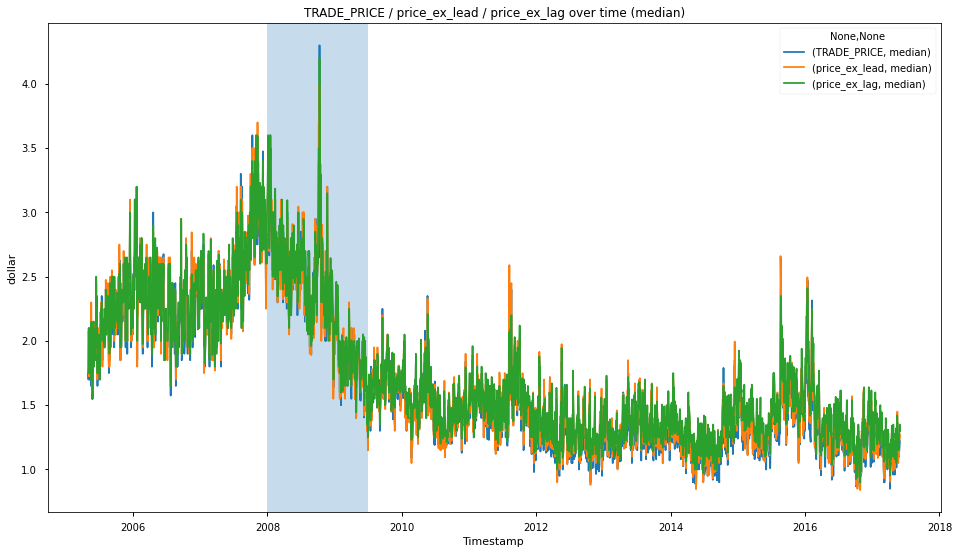

In [81]:
lead_lag_trade_price = data[["TRADE_PRICE", "price_ex_lead", "price_ex_lag"]].groupby(data['date']).agg(['median'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="TRADE_PRICE / price_ex_lead / price_ex_lag over time (median)", xlabel="Timestamp", ylabel="dollar")

plot_recessions()
plt.show()

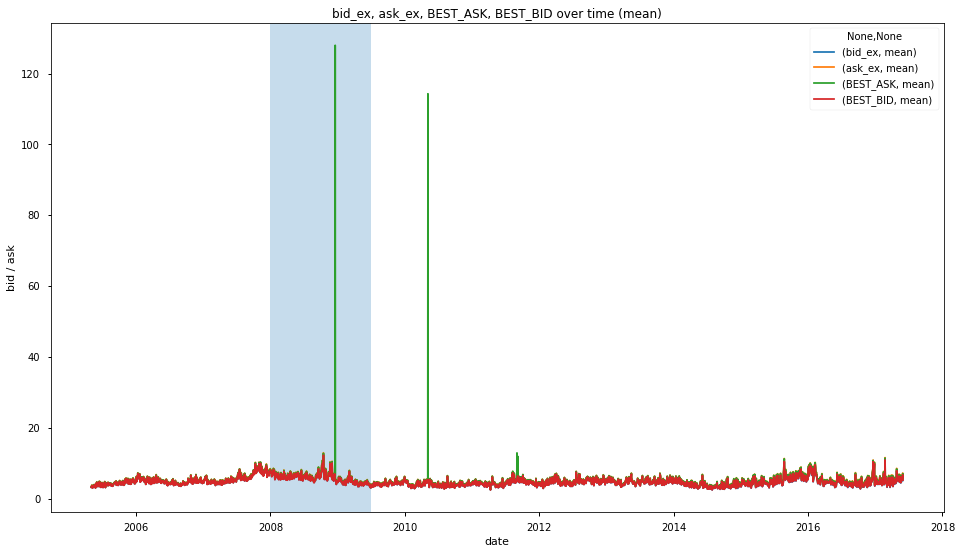

In [82]:
lead_lag_trade_price = data[["bid_ex", "ask_ex", "BEST_ASK", "BEST_BID"]].groupby(data['date']).agg(['mean'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="bid_ex, ask_ex, BEST_ASK, BEST_BID over time (mean)", xlabel="date", ylabel="bid / ask")

plot_recessions()
plt.show()

## Trade size

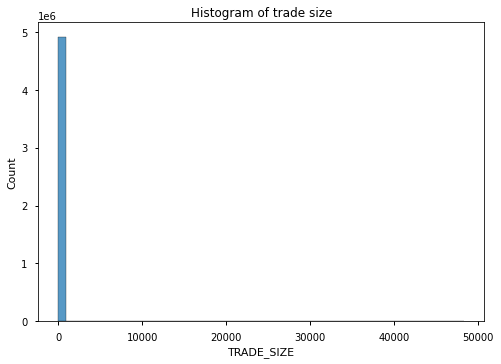

In [83]:
# Think about outliers
ax = sns.histplot(data, x="TRADE_SIZE", bins=50)
ax.title.set_text("Histogram of trade size")

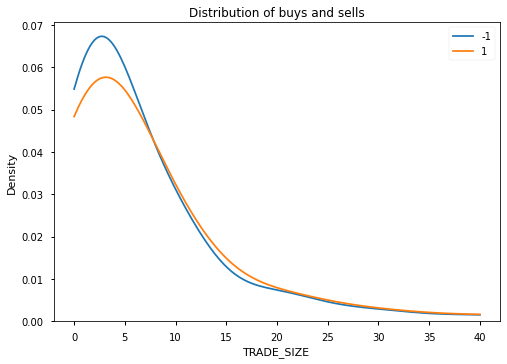

In [84]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="TRADE_SIZE", clip=[0, 40], label=str(i), cumulative=False)
# clip=[-0.5, 0.5]
ax.title.set_text("Distribution of buys and sells")
# ax.xaxis.label.set_text("$x = P_{t} - P_{t}^{mid}$")
ax.legend()
#sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

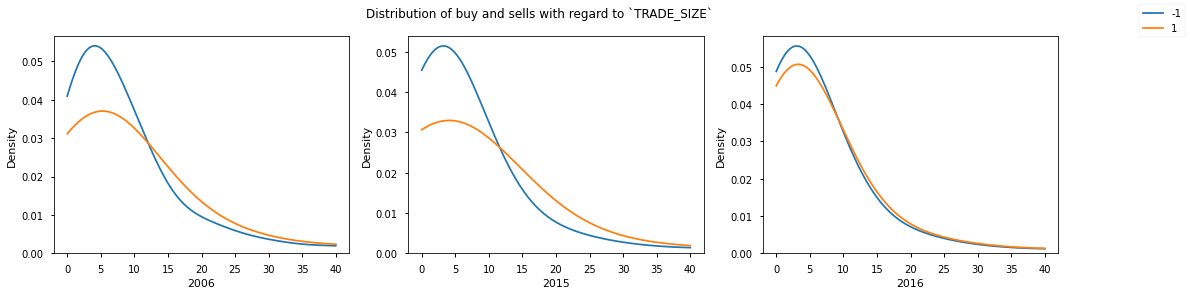

In [85]:
years = [2006, 2015, 2016]
f, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 4))

f.suptitle("Distribution of buy and sells with regard to `TRADE_SIZE`")

for y, year in enumerate(years):
  for i in [-1,1]:
    sns.kdeplot(data=data[(data["buy_sell"]==i) & (data["year"] == year)], x="TRADE_SIZE", clip=[0, 40], label="_" * y + str(i), cumulative=False, common_grid=True, ax=ax[y])
    ax[y].xaxis.label.set_text(str(year))

f.legend()

In [86]:
data.nlargest(N, "TRADE_SIZE", keep='first').T

,39949553,47165585,30910096,34933497,5732573,45655694,8555040,48881325,5609475,47913065
UNDERLYING_SYMBOL,SVU,USO,XLF,USO,XLB,XLF,QQQQ,T,SPY,USO
QUOTE_DATETIME,2015-12-11 15:22:27,2017-02-08 10:48:04,2014-02-03 15:51:17,2015-01-23 15:50:44,2007-07-30 09:39:07,2016-11-11 16:00:42,2008-06-10 14:15:36,2017-05-15 15:22:08,2007-07-16 10:10:40,2017-03-23 10:47:27
SEQUENCE_NUMBER,51029631,17703863,2819929000,66629137,3004135,75442600,86489510,123397990,8557146,21753036
ROOT,SVU,USO,XLF,USO,XLB,XLF,QQQ,T,SFB,USO
EXPIRATION,2016-01-15 00:00:00,2017-05-19 00:00:00,2014-02-22 00:00:00,2015-02-20 00:00:00,2007-09-22 00:00:00,2017-02-17 00:00:00,2008-09-20 00:00:00,2017-07-21 00:00:00,2007-08-18 00:00:00,2017-10-20 00:00:00
STRK_PRC,5.0,10.5,18.0,16.5,36.0,19.0,44.0,42.0,140.0,9.0
OPTION_TYPE,C,P,P,P,P,P,P,C,P,P
TRADE_SIZE,48332,30000,26724,23643,21000,20000,20000,16773,16500,15000
TRADE_PRICE,1.7,0.41,0.02,0.86,0.58,0.24,1.17,0.09,0.3,0.5
BEST_BID,1.55,0.39,0.02,0.83,0.55,0.23,1.15,0.06,0.25,0.48


In [87]:
data["TRADE_SIZE"].describe()

count    4.920375e+06
mean     1.360620e+01
std      7.674520e+01
min      1.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      1.000000e+01
max      4.833200e+04
Name: TRADE_SIZE, dtype: float64

**Observation:**
* highly skewed with few outliers.
* Similar to the price, $\log(\cdot)$ transform helps a little bit.

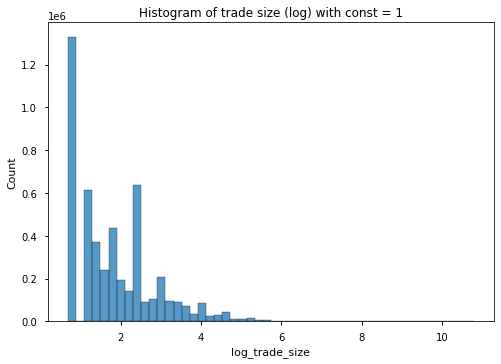

In [88]:
# const not really needed here, due to the trade size being >=1
const = 1
data['log_trade_size'] = np.log(data["TRADE_SIZE"]+const)
ax = sns.histplot(data, x="log_trade_size", bins=50)
ax.title.set_text(f"Histogram of trade size (log) with const = {const}")

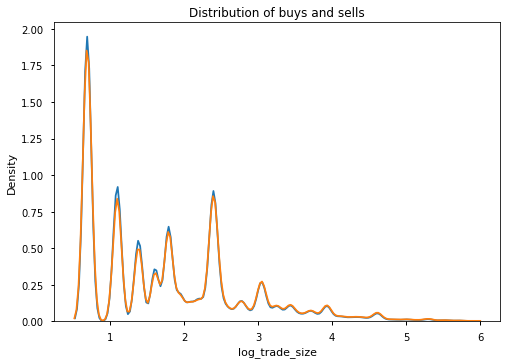

In [89]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="log_trade_size", clip=[0, 6], label=str(i), cumulative=False)
# clip=[-0.5, 0.5]
ax.title.set_text("Distribution of buys and sells")

**Observation:**
- log on size seems to worsen results.
- `TODO:` investigate further, what the reason is. e. g., some skewness, but outliers....

# NaNs 🪲

In [124]:
def visualize_nan():
    """
    Visualize NaN values in a heatmap to learn about patterns.
    """
    plt.subplots()
    sns.heatmap(data.head(50).isnull(), cbar=False)
    plt.xlabel("feature")
    plt.ylabel("row")
    plt.title("Missing values (colored in bright beige)")
    plt.show()

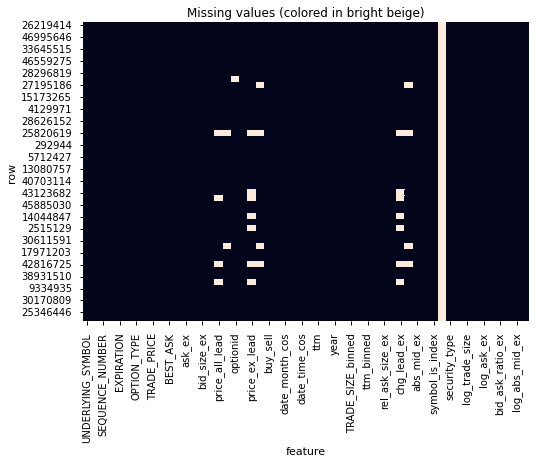

In [125]:
visualize_nan()

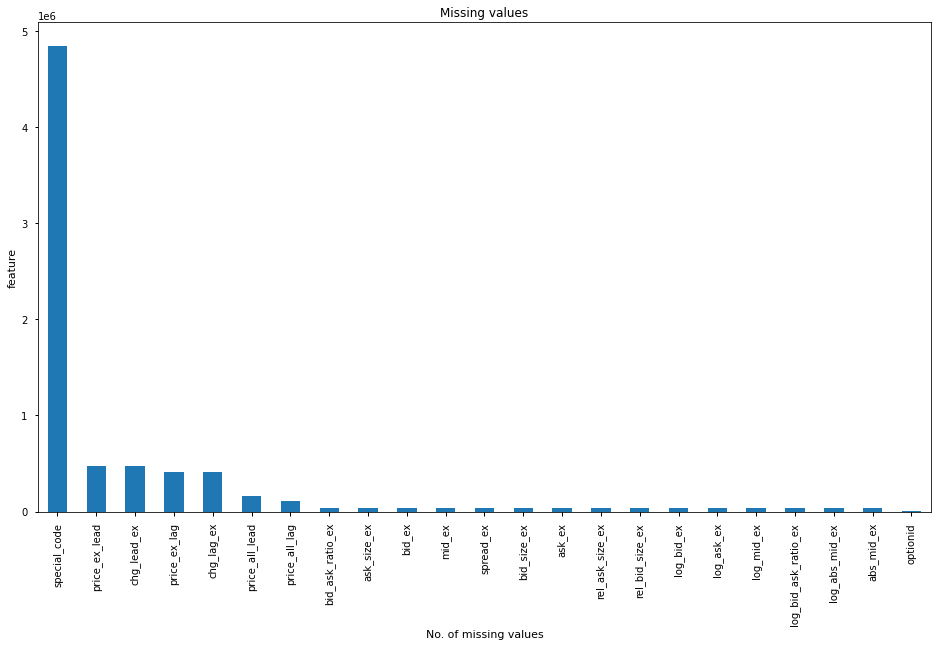

In [126]:
isna_vals = data.isna().sum().sort_values(ascending=False)
isna_vals = isna_vals.loc[lambda x: x > 0]

ax = isna_vals.T.plot(kind="bar", figsize=ratio, legend=False, 
                      xlabel="No. of missing values", 
                      ylabel="feature", 
                      title="Missing values")

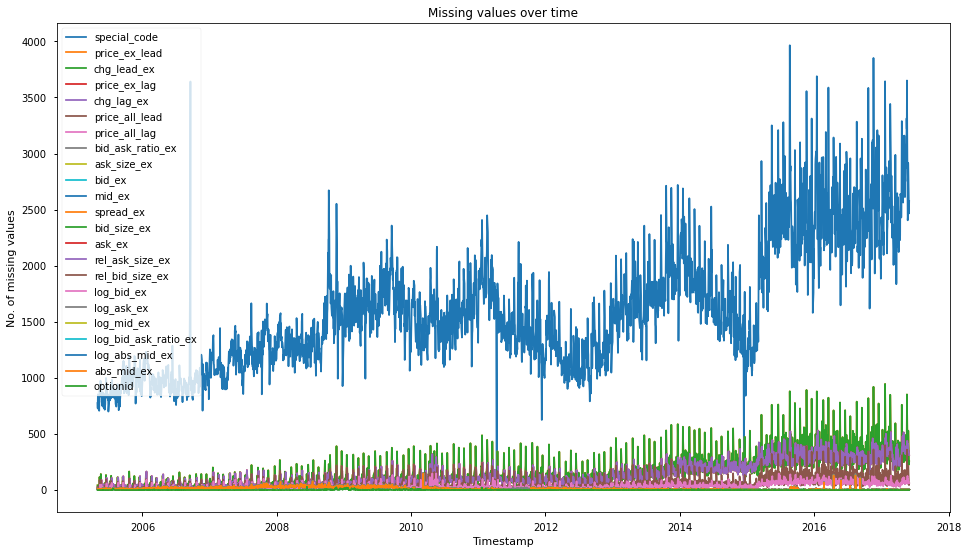

In [127]:
isna_vals_over_time = data[isna_vals.index.tolist()].groupby(data['QUOTE_DATETIME'].dt.date).agg(lambda x: x.isnull().sum())
isna_vals_over_time.plot(kind="line", figsize=ratio, title="Missing values over time", xlabel="Timestamp", ylabel="No. of missing values")

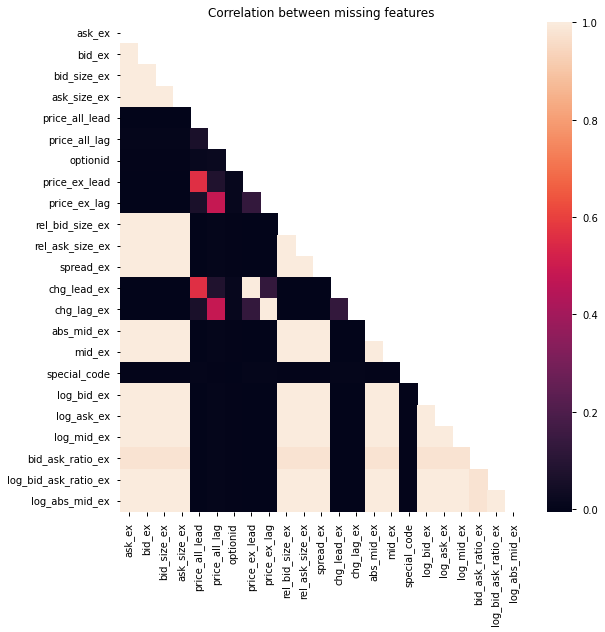

In [128]:
# adapted from: https://github.com/ResidentMario/missingno/blob/master/missingno/missingno.py

isna_data = data.iloc[:, [i for i, n in enumerate(np.var(data.isnull(), axis='rows')) if n > 0]]

corr_mat = isna_data.isnull().corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9,9)) 
ax = sns.heatmap(corr_mat, mask=mask, annot=False, annot_kws={'size':10}, ax=ax)
ax.title.set_text("Correlation between missing features")

In [129]:
# TODO: Check if there is a pattern between the missing values

## distance of trade price from mid ✔️

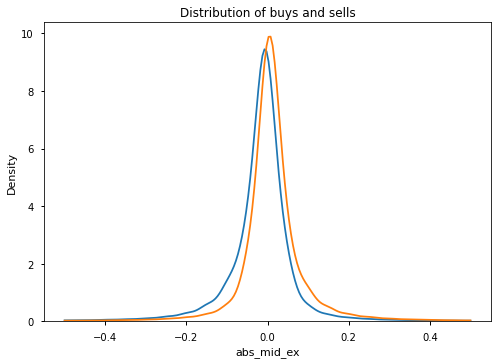

In [112]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="abs_mid_ex", clip=[-0.5,0.5], label=str(i), cumulative=False)
ax.title.set_text(f"Distribution of buys and sells")

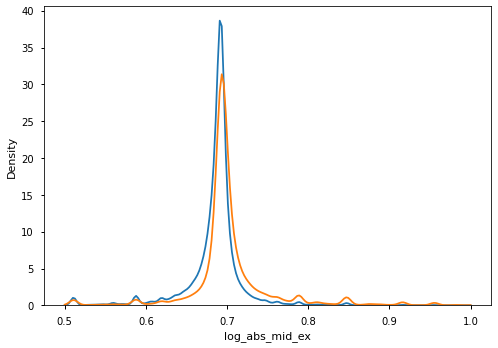

In [113]:
# quotient rule
data["log_abs_mid_ex"] = np.log((data["TRADE_PRICE"] / data["mid_ex"])+1)

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="log_abs_mid_ex", clip=[0.5,1], label=str(i), cumulative=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba62ead790>]],
      dtype=object)

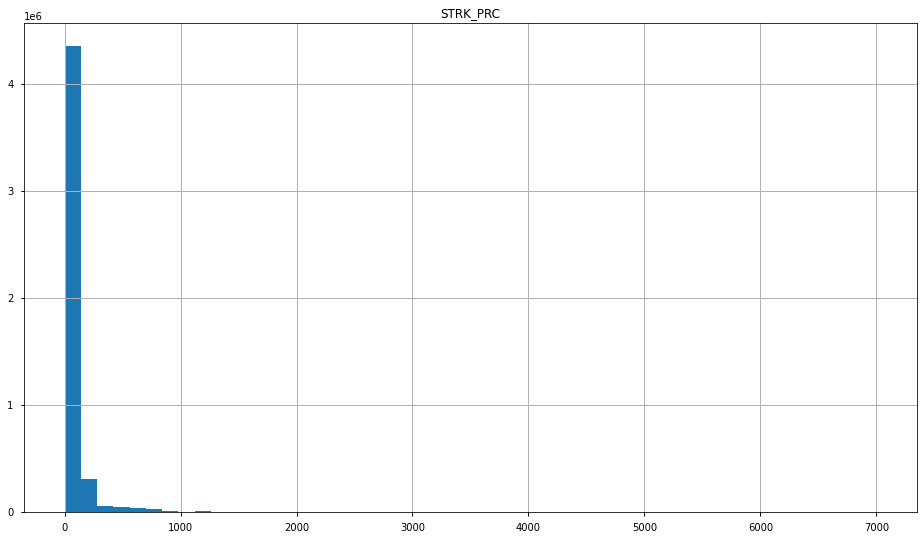

In [122]:
data[["STRK_PRC"]].hist(figsize=ratio, bins=50)

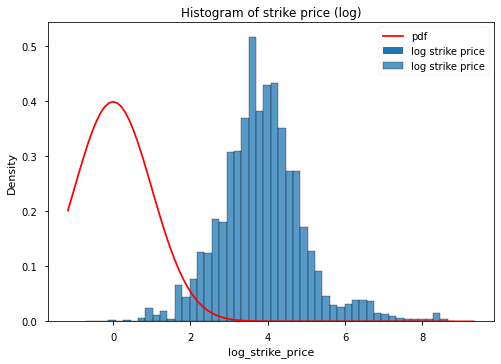

In [123]:
fig, ax = plt.subplots()

data['log_strike_price'] = np.log(data["STRK_PRC"])

ax = sns.histplot(data, x= "log_strike_price", bins=50, stat='density', label="log strike price")
ax.title.set_text("Histogram of strike price (log)")

# extract the limits for the x-axis and fit normal distributon
x0, x1 = ax.get_xlim()  
x_pdf = np.linspace(x0, x1, 100)
y_pdf = stats.norm.pdf(x=x_pdf)

pdf = pd.DataFrame({'x':x_pdf,'y':y_pdf})
sns.lineplot(data = pdf,x='x', y='y',label="pdf", color="r")

## bid-ask-ratio

In [107]:
data["bid_ask_ratio_ex"] = data["ask_ex"] / data["bid_ex"]

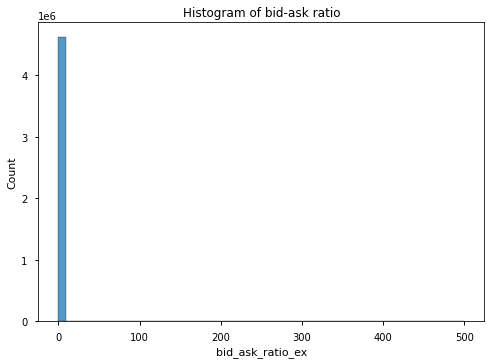

In [108]:
ax = sns.histplot(data, x="bid_ask_ratio_ex", bins=50)
ax.title.set_text("Histogram of bid-ask ratio")

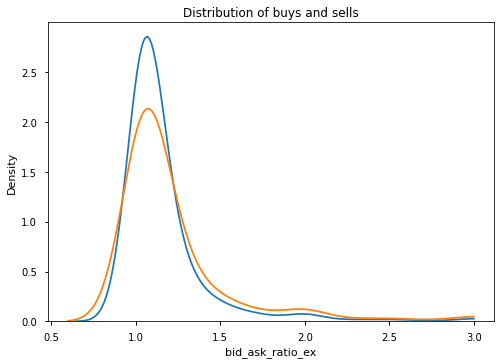

In [109]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="bid_ask_ratio_ex", clip=[0.6,3], label=str(i), cumulative=False)
ax.title.set_text(f"Distribution of buys and sells")

In [110]:
data["log_bid_ask_ratio_ex"] = np.log(data["ask_ex"]+1e-2) - np.log(data["bid_ex"]+1e-2)

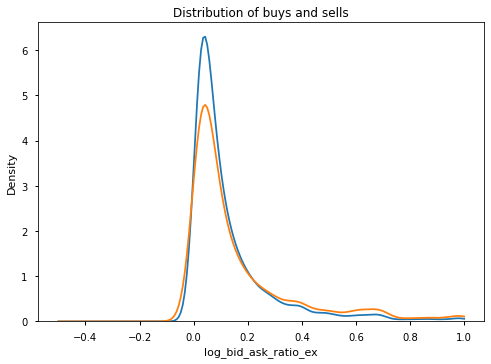

In [111]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="log_bid_ask_ratio_ex",clip=[-0.5, 1], label=str(i), cumulative=False)
ax.title.set_text(f"Distribution of buys and sells")

**Observation:**
- Distribution is the same. This is expected due to $\log$ laws and the $\log$ being a monotonous function.

## ($\log$) mid spread ✔️

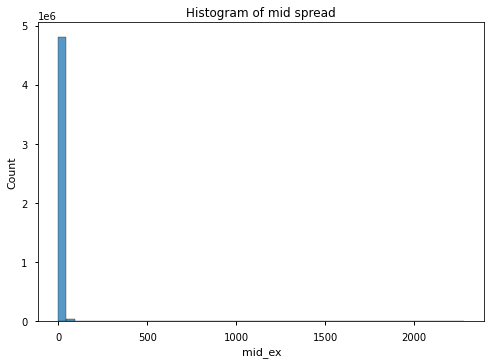

In [101]:
ax = sns.histplot(data, x="mid_ex", bins=50)
ax.title.set_text("Histogram of mid spread")

In [102]:
data["mid_ex"].describe()

count    4.883226e+06
mean     4.987851e+00
std      1.574036e+01
min      0.000000e+00
25%      4.750000e-01
50%      1.550000e+00
75%      4.325000e+00
max      2.280800e+03
Name: mid_ex, dtype: float64

In [103]:
mean_spread = data["spread_ex"].groupby(data['date']).agg(['mean'])

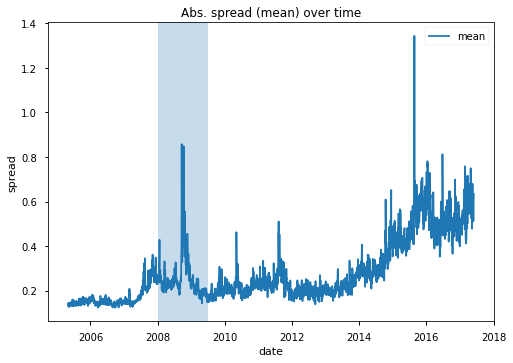

In [104]:
ax = sns.lineplot(mean_spread)
ax.title.set_text("Abs. spread (mean) over time")
ax.yaxis.label.set_text("spread")
plot_recessions()
plt.show()

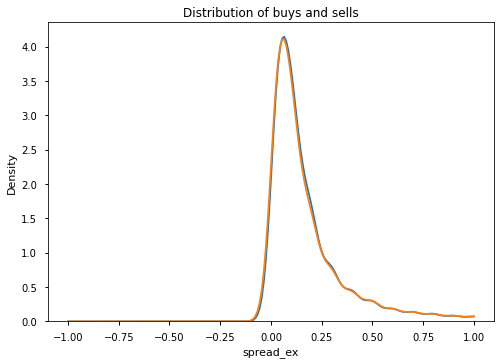

In [105]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="spread_ex", clip=[-1,1], label=str(i), cumulative=False)
ax.title.set_text(f"Distribution of buys and sells")

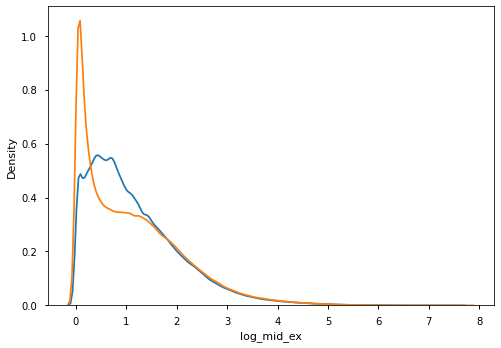

In [106]:
# quotient rule
const = 1
data["log_mid_ex"] = np.log(data["mid_ex"]+const)

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="log_mid_ex", label=str(i), cumulative=False)
ax.title.set_text(f"Distribution of buys and sells after log with const = {const}")

# Correlations of engineered features 🎲

# Bid, Ask, and Spread 🛍️

## ($\log$) bid ex ✔️

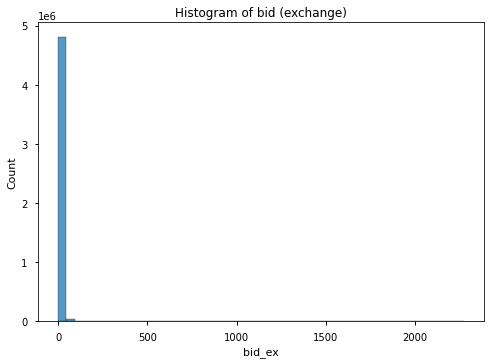

In [90]:
ax = sns.histplot(data, x="bid_ex", bins=50)
ax.title.set_text("Histogram of bid (exchange)")

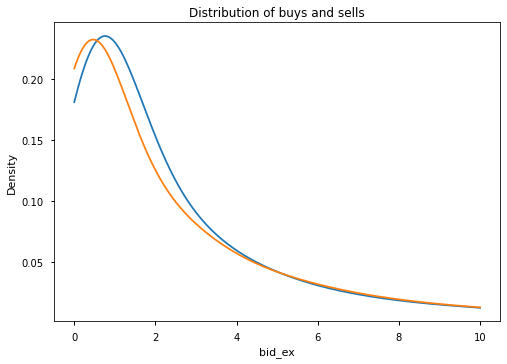

In [91]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="bid_ex", clip=[0, 10], label=str(i), cumulative=False)

ax.title.set_text("Distribution of buys and sells")

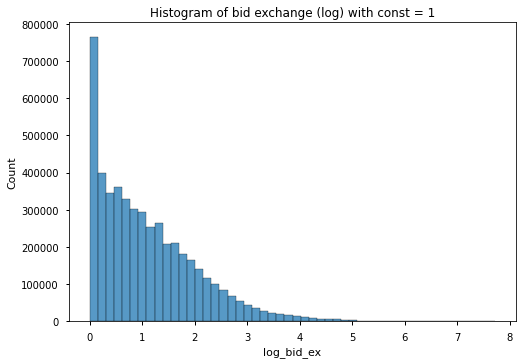

In [92]:
const = 1
data['log_bid_ex'] = np.log(data["bid_ex"]+const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)
ax.title.set_text(f"Histogram of bid exchange (log) with const = {const}")

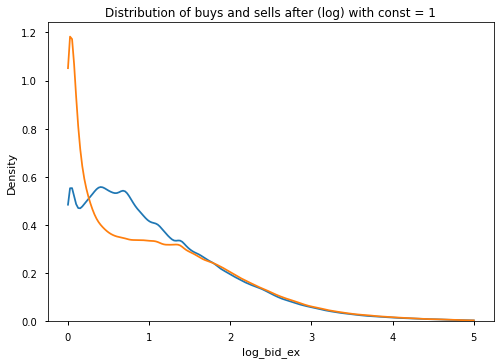

In [93]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="log_bid_ex", clip=[0, 5], label=str(i), cumulative=False)
ax.title.set_text(f"Distribution of buys and sells after (log) with const = {const}")

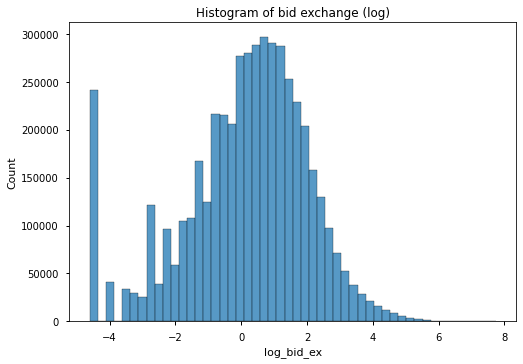

In [94]:
const = 1e-2
data['log_bid_ex'] = np.log(data["bid_ex"]+const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)
ax.title.set_text("Histogram of bid exchange (log)")

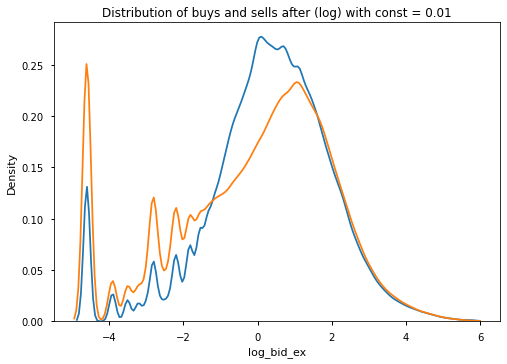

In [95]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="log_bid_ex", clip=[-5, 6], label=str(i), cumulative=False)

ax.title.set_text(f"Distribution of buys and sells after (log) with const = {const}")

**Observation:**
- One can choose different constants, but small constants, e. g., `const=1e-2` gives fuzzy results. Better choose larger constant like `const=1`.

## ($\log$) ask ex ✔️

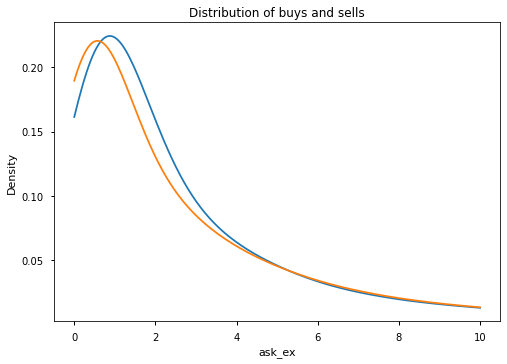

In [96]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="ask_ex", clip=[0, 10], label=str(i), cumulative=False)

ax.title.set_text("Distribution of buys and sells")

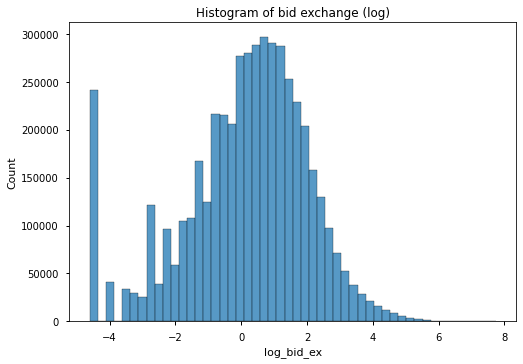

In [97]:
const = 1
data['log_ask_ex'] = np.log(data["ask_ex"]+const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)
ax.title.set_text("Histogram of bid exchange (log)")

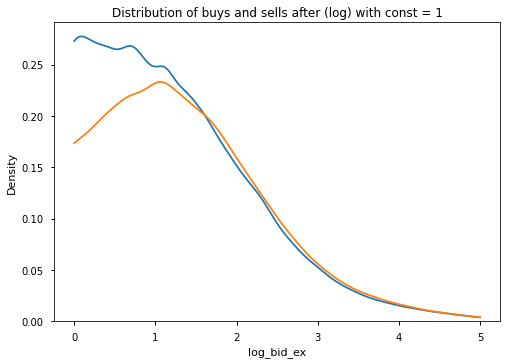

In [98]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="log_bid_ex", clip=[0, 5], label=str(i), cumulative=False)
ax.title.set_text(f"Distribution of buys and sells after (log) with const = {const}")

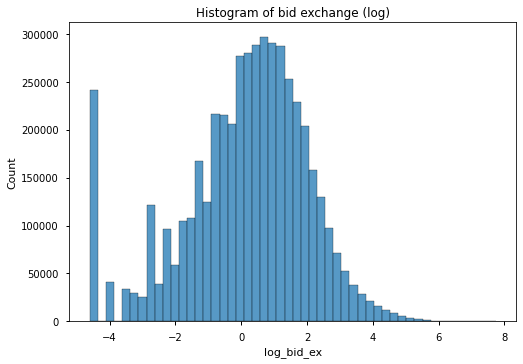

In [99]:
const = 1e-2
data['log_ask_ex'] = np.log(data["ask_ex"]+const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)
ax.title.set_text("Histogram of bid exchange (log)")

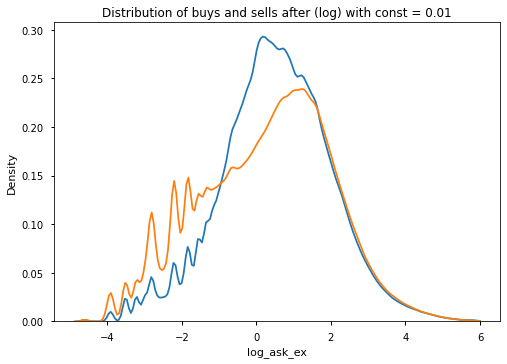

In [100]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="log_ask_ex", clip=[-5, 6], label=str(i), cumulative=False)
ax.title.set_text(f"Distribution of buys and sells after (log) with const = {const}")

### Date features ⏰

In [ ]:
date_cols = data.columns[data.columns.str.startswith("date_")].tolist()

date_target_cols = [*date_cols, "buy_sell", "day","month" , "year"]

corr = data[date_target_cols].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [ ]:
sort_criteria = corr["buy_sell"].abs().sort_values(ascending=False)
corr_target = corr.sort_values("buy_sell", ascending=False)["buy_sell"]
corr_target.loc[sort_criteria.index].to_frame()

**Observation:**
* Correlation with date features is relatively high if compared with other classical features.
* For day correlation is highest, if the day is not mapped to a unit circle. But $\sin$ and $\cos$ have a greater feature importance together.

In [ ]:
kde_target("day")

In [ ]:
kde_target("date_year_min")

**Observation:**
* Judging from the plot there seems to be a seasonal pattern e. g., more buys 
at the beginning of the month and more sells towards the end of the month. 
* Due to the distributions it could make sense to include date features in some feature sets.